In [1]:
'''
Deep learning methods

Author: Saeed Yousefi

Last edit on 6/15/2022
'''

'\nDeep learning methods\n\nAuthor: Saeed Yousefi\n\nLast edit on 6/15/2022\n'

In [2]:
# For saving the outputs and models
!mkdir files_DL
!mkdir models

In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import tensorflow as tf
import xgboost as xgb
import os
import warnings
from sklearn.metrics import mean_absolute_error
from keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU, Conv1D, MaxPooling1D,TimeDistributed, Flatten, Dropout, RepeatVector
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss, ccf
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from math import sqrt
import keras.backend as K

%matplotlib inline

warnings.simplefilter(action='ignore', category=(FutureWarning, UserWarning))


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# **Data Preprocessing**

In [4]:
df = pd.read_csv('solar_a.csv')
df = df.iloc[1:, :]
df.head()

,Date,Hour,Cloud coverage,Visibility,Temperature,Dew point,Relative humidity,Wind speed,Station pressure,Altimeter,Solar energy
1,2/1/2016,1,0.0,7.88,1.16,0.62,91.04,7.04,29.11,29.90,0.0
2,2/1/2016,2,0.0,9.84,1.22,0.96,89.28,8.96,29.12,29.91,0.0
3,2/1/2016,3,0.0,9.84,1.02,0.61,89.12,6.36,29.14,29.93,0.0
4,2/1/2016,4,0.0,9.88,0.83,0.45,90.08,6.12,29.15,29.94,0.0
5,2/1/2016,5,0.0,9.84,0.77,0.10,85.44,5.08,29.16,29.95,0.0


In [5]:
df['Time'] = pd.to_datetime(df['Date'])
df = df.drop(['Date'], axis=1)
df = df.set_index('Time')

In [6]:
for i in range(len(df)):
    position = df.index[i]
    #hour = position.hour
    day = position.day
    month = position.month
    df.loc[position, 'Month'] = month
    df.loc[position, 'Day'] = day

In [7]:
df = df.drop(['Visibility', 'Altimeter'], axis=1)

In [8]:
df.head()

,Hour,Cloud coverage,Temperature,Dew point,Relative humidity,Wind speed,Station pressure,Solar energy,Month,Day
Time,,,,,,,,,,
2016-02-01,1,0.0,1.16,0.62,91.04,7.04,29.11,0.0,2.0,1.0
2016-02-01,2,0.0,1.22,0.96,89.28,8.96,29.12,0.0,2.0,1.0
2016-02-01,3,0.0,1.02,0.61,89.12,6.36,29.14,0.0,2.0,1.0
2016-02-01,4,0.0,0.83,0.45,90.08,6.12,29.15,0.0,2.0,1.0
2016-02-01,5,0.0,0.77,0.10,85.44,5.08,29.16,0.0,2.0,1.0


In [9]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size
        
    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])
        
        if single_step:
            labels.append(target[i + target_size])
        else:
            labels.append(target[i : i + target_size])

    return np.array(data), np.array(labels)

In [10]:
l = len(df)
train_end_idx = int(0.6*l)
cv_end_idx = int(0.9*l)
test_end_idx = l

In [11]:
X = df[df.columns.drop('Solar energy')].values
y = df['Solar energy'].values

y = y.reshape(-1, 1)

In [12]:
scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

In [13]:
scaler_X.fit(X[:train_end_idx])
scaler_y.fit(y[:train_end_idx])

MinMaxScaler()

In [14]:
X_norm = scaler_X.transform(X)
y_norm = scaler_y.transform(y)

In [15]:
dataset_norm = np.concatenate((X_norm, y_norm), axis=1)

past_history = 30
future_target = 0

In [16]:
X_train, y_train = multivariate_data(dataset_norm, dataset_norm[:, -1],
                                     0, train_end_idx, past_history, 
                                     future_target, step=1, single_step=True)

X_val, y_val = multivariate_data(dataset_norm, dataset_norm[:, -1],
                                 train_end_idx, cv_end_idx, past_history, 
                                 future_target, step=1, single_step=True)

X_test, y_test = multivariate_data(dataset_norm, dataset_norm[:, -1],
                                   cv_end_idx, test_end_idx, past_history, 
                                   future_target, step=1, single_step=True)

In [17]:
batch_size = 128
buffer_size = 1000

In [18]:
train = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train = train.cache().shuffle(buffer_size).batch(batch_size).prefetch(1)

validation = tf.data.Dataset.from_tensor_slices((X_val, y_val))
validation = validation.batch(batch_size).prefetch(1)

In [19]:
y_test = y_test.reshape(-1, 1)
y_test_inv = scaler_y.inverse_transform(y_test)

In [20]:
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1)) 

In [21]:
# Define some common parameters

input_shape = X_train.shape[-2:]
loss = root_mean_squared_error
metric = ['mse', 'mae']
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
              lambda epoch: 1e-4 * 10**(epoch / 10))
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss' ,patience=20)

In [22]:
def plot_model_loss(history, name):
    
    # Evaluate train and validation accuracies and losses
    
    #train_rmse = history.history['root_mean_squared_error']
    #val_rmse = history.history['val_root_mean_squared_error']
    
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    # Visualize epochs vs. train and validation accuracies and losses
    
    # plt.figure(figsize=(20, 10))
    # plt.subplot(1, 2, 1)
    # plt.plot(train_rmse, label='Training RMSE')
    # plt.plot(val_rmse, label='Validation RMSE')
    # plt.legend()
    # plt.title('Epochs vs. Training and Validation RMSE')
    plt.figure(figsize=(20, 10))
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend()
    plt.title('Epochs vs. Training and Validation Loss')
    plt.savefig(name, format='png')
    plt.show()

In [23]:
def plot_learning_rate_schedule(history_lr, max_loss, name):
    plt.figure(figsize=(10, 5))
    plt.semilogx(history_lr.history['lr'], history_lr.history['loss'])
    plt.axis([1e-4, 1, 0, max_loss])
    plt.xlabel('Learning Rate')
    plt.ylabel('Training Loss')
    plt.savefig(name, format='png')
    plt.show()

# **LSTM**

In [24]:
tf.keras.backend.clear_session()

multivariate_lstm = tf.keras.models.Sequential([
    LSTM(100, input_shape=input_shape, 
         return_sequences=True),
    Flatten(),
    Dense(200, activation='relu'),
    Dropout(0.20),
    Dense(1)
])

optimizer = tf.keras.optimizers.Adam(lr=1e-4, amsgrad=True)

multivariate_lstm.compile(loss=loss,
                          optimizer=optimizer,
                          metrics=metric)


In [25]:
history_lr = multivariate_lstm.fit(train, epochs=50,
                                validation_data=validation,
                                callbacks=[lr_schedule])

Epoch 1/50
71/71 [==============================] - 8s 14ms/step - loss: 0.1283 - mse: 0.0363 - mae: 0.1283 - val_loss: 0.1185 - val_mse: 0.0371 - val_mae: 0.1185 - lr: 1.0000e-04
Epoch 2/50
71/71 [==============================] - 1s 8ms/step - loss: 0.0850 - mse: 0.0202 - mae: 0.0850 - val_loss: 0.0863 - val_mse: 0.0230 - val_mae: 0.0863 - lr: 1.2589e-04
Epoch 3/50
71/71 [==============================] - 1s 7ms/step - loss: 0.0709 - mse: 0.0166 - mae: 0.0709 - val_loss: 0.0808 - val_mse: 0.0210 - val_mae: 0.0808 - lr: 1.5849e-04
Epoch 4/50
71/71 [==============================] - 1s 7ms/step - loss: 0.0626 - mse: 0.0141 - mae: 0.0626 - val_loss: 0.0793 - val_mse: 0.0205 - val_mae: 0.0793 - lr: 1.9953e-04
Epoch 5/50
71/71 [==============================] - 1s 7ms/step - loss: 0.0601 - mse: 0.0134 - mae: 0.0601 - val_loss: 0.0757 - val_mse: 0.0192 - val_mae: 0.0757 - lr: 2.5119e-04
Epoch 6/50
71/71 [==============================] - 1s 7ms/step - loss: 0.0578 - mse: 0.0123 - mae: 0.05

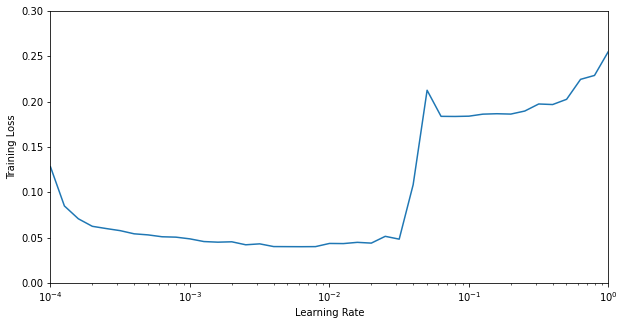

In [26]:
name = '/content/files_DL/lstm_history_lr.png'
plot_learning_rate_schedule(history_lr, 0.3, name)

In [27]:
tf.keras.backend.clear_session()

multivariate_lstm = tf.keras.models.Sequential([
    LSTM(100, input_shape=input_shape, 
         return_sequences=True),
    Flatten(),
    Dense(200, activation='relu'),
    Dropout(0.20),
    Dense(1)
])

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
                   '/content/models/multivariate_lstm.h5', monitor=('val_loss'), save_best_only=True)
optimizer = tf.keras.optimizers.Adam(lr=0.002, amsgrad=True)

multivariate_lstm.compile(loss=loss,
                          optimizer=optimizer,
                          metrics=metric)
multivariate_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 100)           44400     
                                                                 
 flatten (Flatten)           (None, 3000)              0         
                                                                 
 dense (Dense)               (None, 200)               600200    
                                                                 
 dropout (Dropout)           (None, 200)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 201       
                                                                 
Total params: 644,801
Trainable params: 644,801
Non-trainable params: 0
_________________________________________________________________


In [28]:
history = multivariate_lstm.fit(train, epochs=1000,
                                validation_data=validation,
                                callbacks=[early_stopping,model_checkpoint])

Epoch 1/1000
71/71 [==============================] - 3s 14ms/step - loss: 0.1862 - mse: 0.2564 - mae: 0.1862 - val_loss: 0.0885 - val_mse: 0.0256 - val_mae: 0.0885
Epoch 2/1000
71/71 [==============================] - 1s 8ms/step - loss: 0.0673 - mse: 0.0166 - mae: 0.0673 - val_loss: 0.0875 - val_mse: 0.0245 - val_mae: 0.0875
Epoch 3/1000
71/71 [==============================] - 1s 8ms/step - loss: 0.0614 - mse: 0.0138 - mae: 0.0614 - val_loss: 0.0762 - val_mse: 0.0186 - val_mae: 0.0762
Epoch 4/1000
71/71 [==============================] - 1s 8ms/step - loss: 0.0529 - mse: 0.0105 - mae: 0.0529 - val_loss: 0.0681 - val_mse: 0.0150 - val_mae: 0.0681
Epoch 5/1000
71/71 [==============================] - 1s 8ms/step - loss: 0.0497 - mse: 0.0095 - mae: 0.0497 - val_loss: 0.0655 - val_mse: 0.0137 - val_mae: 0.0655
Epoch 6/1000
71/71 [==============================] - 1s 8ms/step - loss: 0.0471 - mse: 0.0086 - mae: 0.0471 - val_loss: 0.0624 - val_mse: 0.0124 - val_mae: 0.0624
Epoch 7/1000
71

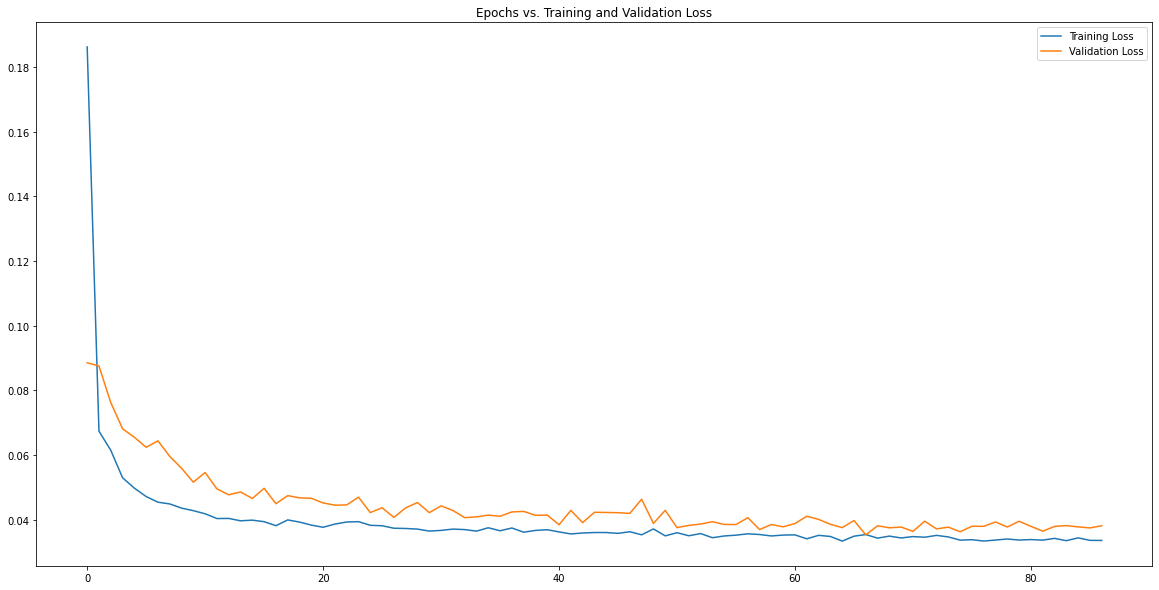

In [29]:
name = '/content/files_DL/lstm.png'
plot_model_loss(history, name)

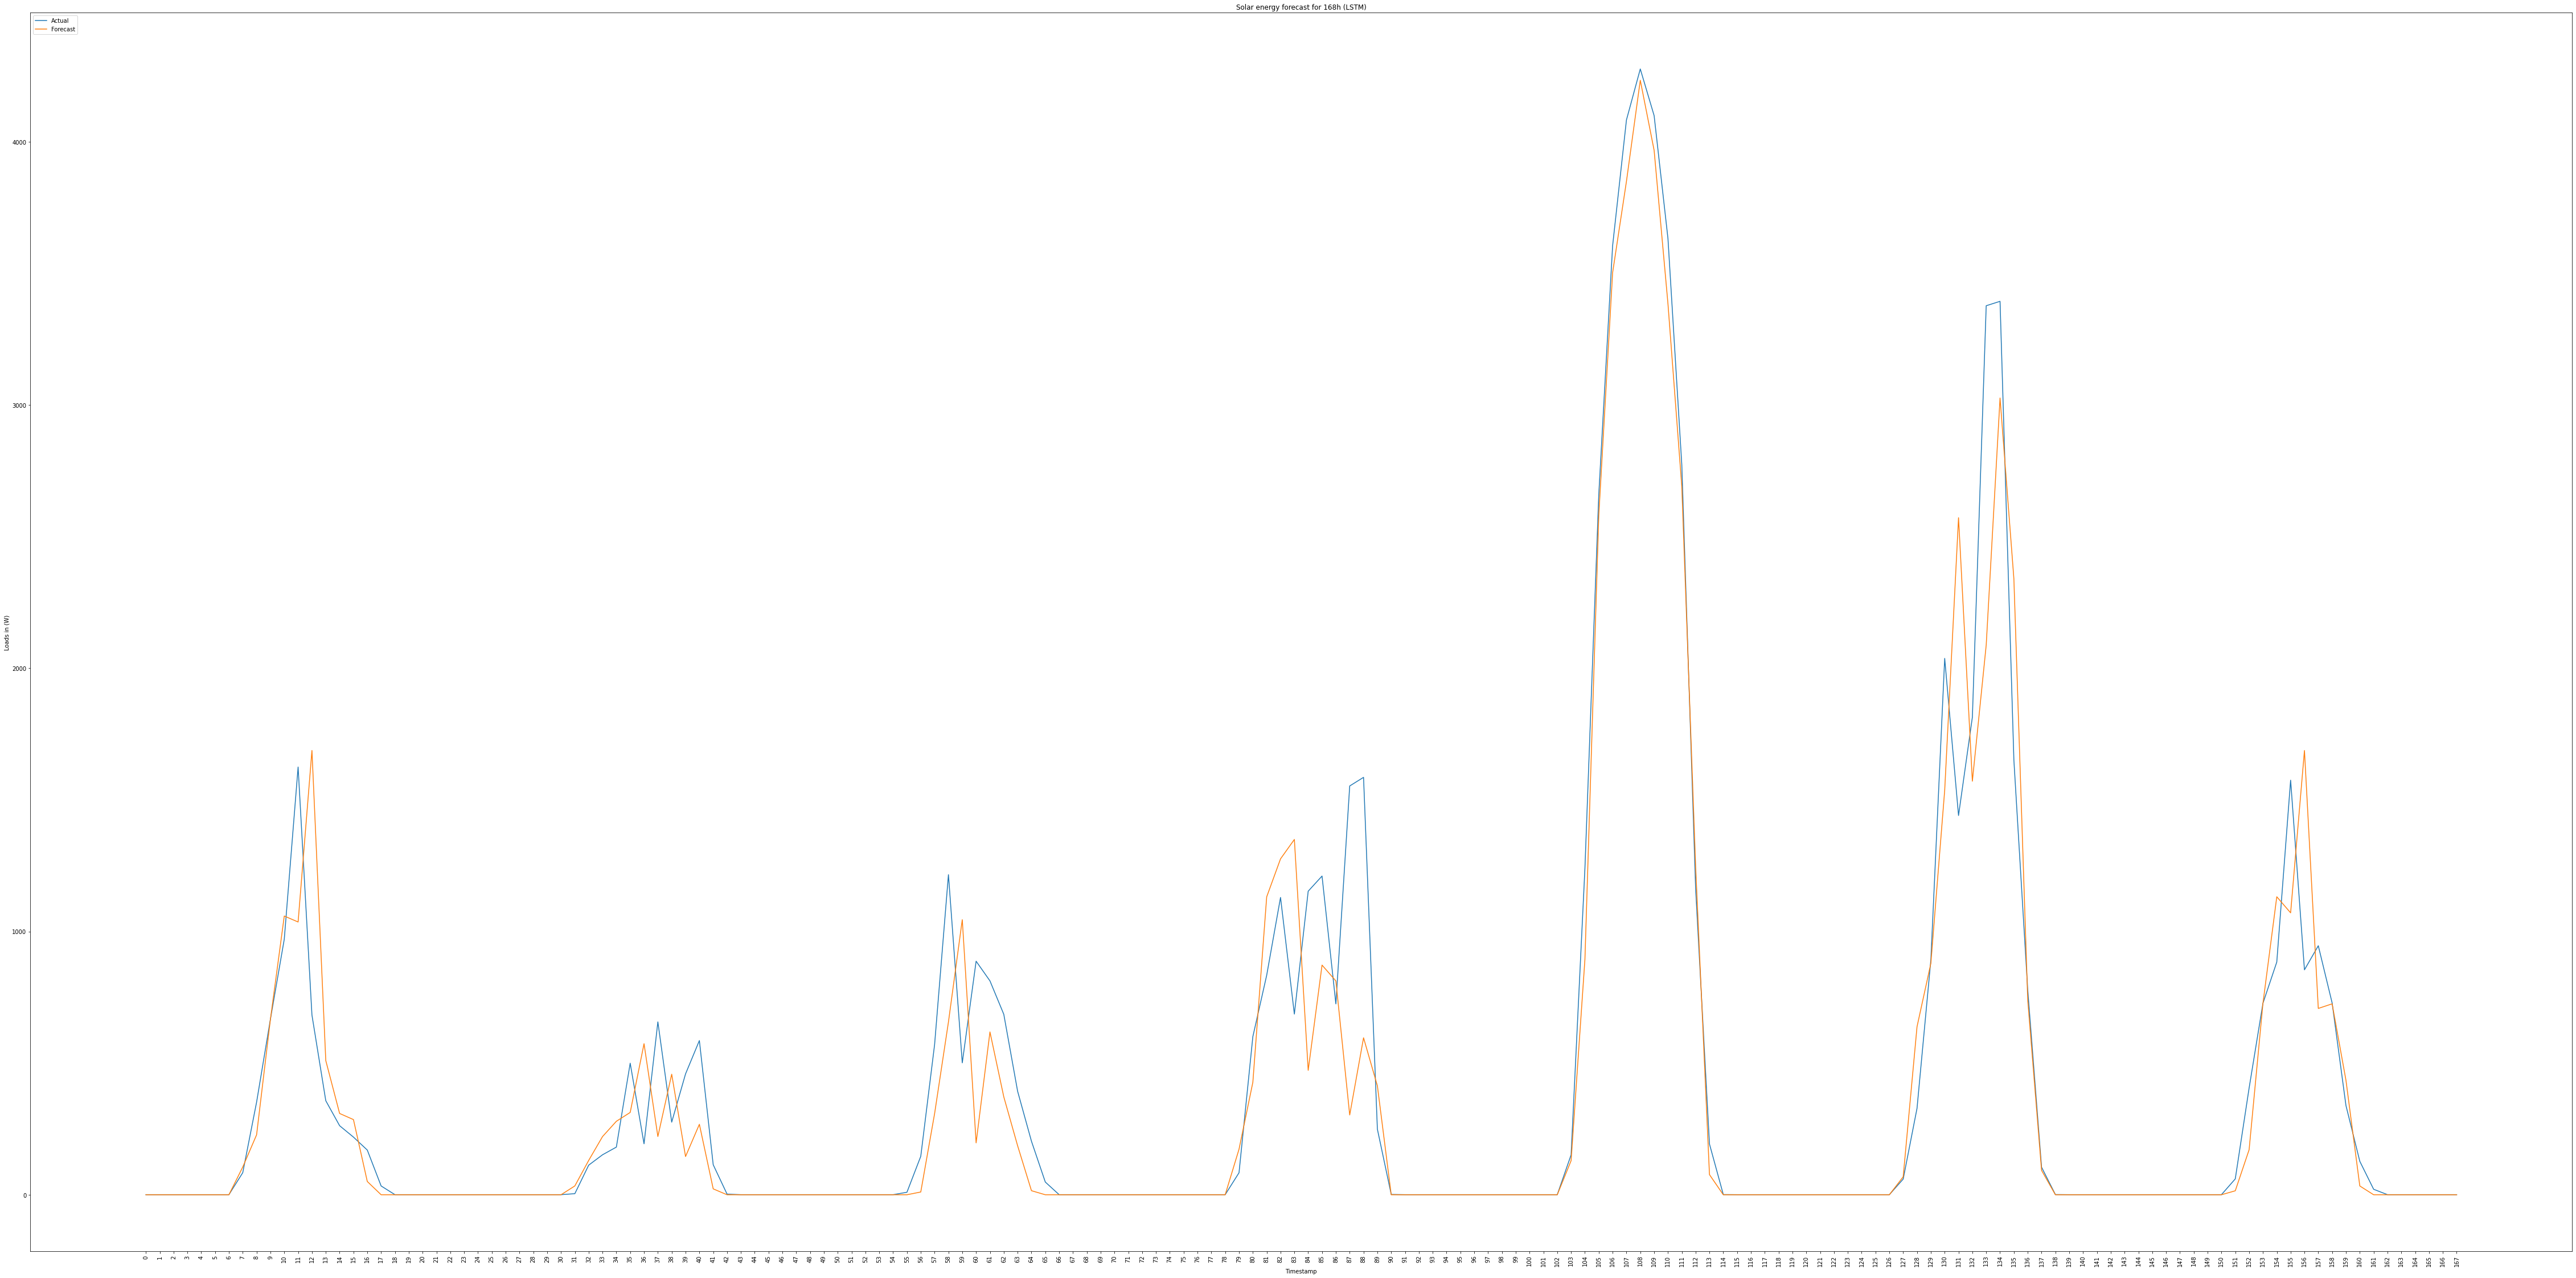

In [30]:
forecast = multivariate_lstm.predict(X_test[-168:])
lstm_forecast = scaler_y.inverse_transform(forecast)


x = []
for i in range(168):
  x.append(str(i))

plt.figure(figsize=(80, 40))
plt.plot(x,scaler_y.inverse_transform(y_test[-168:]), label="Actual")
plt.plot(x,lstm_forecast, label="Forecast")

plt.legend(loc="upper left")

plt.xticks(x)
plt.xlabel('Timestamp')
plt.ylabel('Loads in (W)')
plt.title('Solar energy forecast for 168h (LSTM)')
plt.xticks(rotation = 90)
plt.savefig('/content/files_DL/lstm_forecast_actual.png', fontsize=50)
plt.show()

In [31]:
multivariate_lstm = tf.keras.models.load_model('/content/models/multivariate_lstm.h5',
              custom_objects={'root_mean_squared_error':root_mean_squared_error})

forecast = multivariate_lstm.predict(X_test)
lstm_forecast = scaler_y.inverse_transform(forecast)

rmse_lstm_n = sqrt(mean_squared_error(y_test,
                                    forecast))
print('RMSE (Normalized) of LSTM forecast: {}'
      .format(round(rmse_lstm_n, 8)))

rmse_lstm = sqrt(mean_squared_error(y_test_inv,
                                    lstm_forecast))
print('RMSE of LSTM forecast: {}'
      .format(round(rmse_lstm, 4)))

mae_lstm_n = mean_absolute_error(y_test,
                                    forecast)
print('MAE (Normalized) of LSTM forecast: {}'
      .format(round(mae_lstm_n, 8)))

mae_lstm = mean_absolute_error(y_test_inv,
                                    lstm_forecast)
print('MAE of LSTM forecast: {}'
      .format(round(mae_lstm, 4)))

RMSE (Normalized) of LSTM forecast: 0.05971335
RMSE of LSTM forecast: 282.0261
MAE (Normalized) of LSTM forecast: 0.02778171
MAE of LSTM forecast: 131.213


# **GRU**

In [32]:
tf.keras.backend.clear_session()

multivariate_gru = tf.keras.models.Sequential([
    GRU(100, input_shape=input_shape, 
         return_sequences=True),
    Flatten(),
    Dense(200, activation='relu'),
    Dropout(0.20),
    Dense(1)
])

optimizer = tf.keras.optimizers.Adam(lr=1e-4, amsgrad=True)

multivariate_gru.compile(loss=loss,
                          optimizer=optimizer,
                          metrics=metric)

In [33]:
history_lr = multivariate_gru.fit(train, epochs=50,
                                validation_data=validation,
                                callbacks=[lr_schedule])

Epoch 1/50
71/71 [==============================] - 2s 13ms/step - loss: 0.1186 - mse: 0.0296 - mae: 0.1186 - val_loss: 0.1096 - val_mse: 0.0274 - val_mae: 0.1096 - lr: 1.0000e-04
Epoch 2/50
71/71 [==============================] - 1s 7ms/step - loss: 0.0787 - mse: 0.0165 - mae: 0.0787 - val_loss: 0.0826 - val_mse: 0.0193 - val_mae: 0.0826 - lr: 1.2589e-04
Epoch 3/50
71/71 [==============================] - 1s 8ms/step - loss: 0.0643 - mse: 0.0132 - mae: 0.0643 - val_loss: 0.0725 - val_mse: 0.0174 - val_mae: 0.0725 - lr: 1.5849e-04
Epoch 4/50
71/71 [==============================] - 1s 7ms/step - loss: 0.0565 - mse: 0.0115 - mae: 0.0565 - val_loss: 0.0708 - val_mse: 0.0167 - val_mae: 0.0708 - lr: 1.9953e-04
Epoch 5/50
71/71 [==============================] - 1s 7ms/step - loss: 0.0524 - mse: 0.0103 - mae: 0.0524 - val_loss: 0.0748 - val_mse: 0.0186 - val_mae: 0.0748 - lr: 2.5119e-04
Epoch 6/50
71/71 [==============================] - 0s 7ms/step - loss: 0.0521 - mse: 0.0102 - mae: 0.05

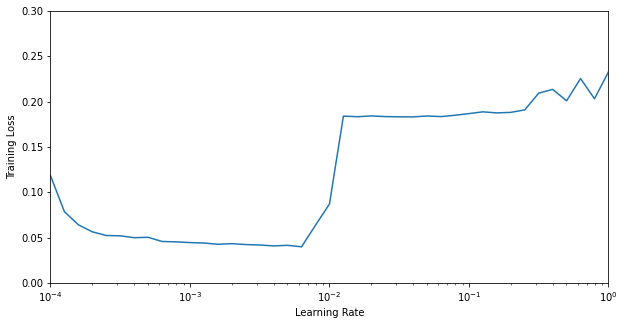

In [34]:
name = '/content/files_DL/gru_history_lr.png'
plot_learning_rate_schedule(history_lr, 0.3, name)

In [35]:
tf.keras.backend.clear_session()

multivariate_gru = tf.keras.models.Sequential([
    GRU(100, input_shape=input_shape, 
         return_sequences=True),
    Flatten(),
    Dense(200, activation='relu'),
    Dropout(0.20),
    Dense(1)
])

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
                   '/content/models/multivariate_gru.h5', monitor=('val_loss'), save_best_only=True)
optimizer = tf.keras.optimizers.Adam(lr=0.002, amsgrad=True)

multivariate_gru.compile(loss=loss,
                          optimizer=optimizer,
                          metrics=metric)
multivariate_gru.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 30, 100)           33600     
                                                                 
 flatten (Flatten)           (None, 3000)              0         
                                                                 
 dense (Dense)               (None, 200)               600200    
                                                                 
 dropout (Dropout)           (None, 200)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 201       
                                                                 
Total params: 634,001
Trainable params: 634,001
Non-trainable params: 0
_________________________________________________________________


In [36]:
history = multivariate_gru.fit(train, epochs=1000,
                                validation_data=validation,
                                callbacks=[early_stopping,model_checkpoint])

Epoch 1/1000
71/71 [==============================] - 3s 13ms/step - loss: 0.1247 - mse: 0.0657 - mae: 0.1247 - val_loss: 0.0816 - val_mse: 0.0218 - val_mae: 0.0816
Epoch 2/1000
71/71 [==============================] - 1s 8ms/step - loss: 0.0567 - mse: 0.0122 - mae: 0.0567 - val_loss: 0.0746 - val_mse: 0.0176 - val_mae: 0.0746
Epoch 3/1000
71/71 [==============================] - 1s 7ms/step - loss: 0.0518 - mse: 0.0100 - mae: 0.0518 - val_loss: 0.0707 - val_mse: 0.0158 - val_mae: 0.0707
Epoch 4/1000
71/71 [==============================] - 1s 8ms/step - loss: 0.0478 - mse: 0.0087 - mae: 0.0478 - val_loss: 0.0591 - val_mse: 0.0112 - val_mae: 0.0591
Epoch 5/1000
71/71 [==============================] - 1s 8ms/step - loss: 0.0459 - mse: 0.0082 - mae: 0.0459 - val_loss: 0.0541 - val_mse: 0.0096 - val_mae: 0.0541
Epoch 6/1000
71/71 [==============================] - 1s 7ms/step - loss: 0.0438 - mse: 0.0076 - mae: 0.0438 - val_loss: 0.0527 - val_mse: 0.0089 - val_mae: 0.0527
Epoch 7/1000
71

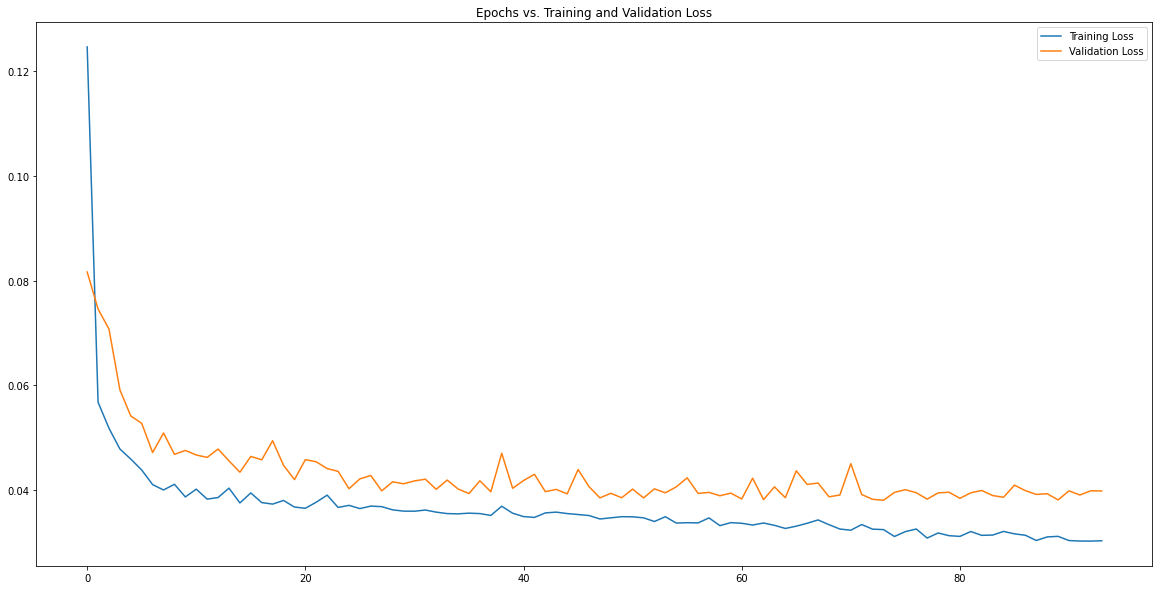

In [37]:
name = '/content/files_DL/gru.png'
plot_model_loss(history, name)

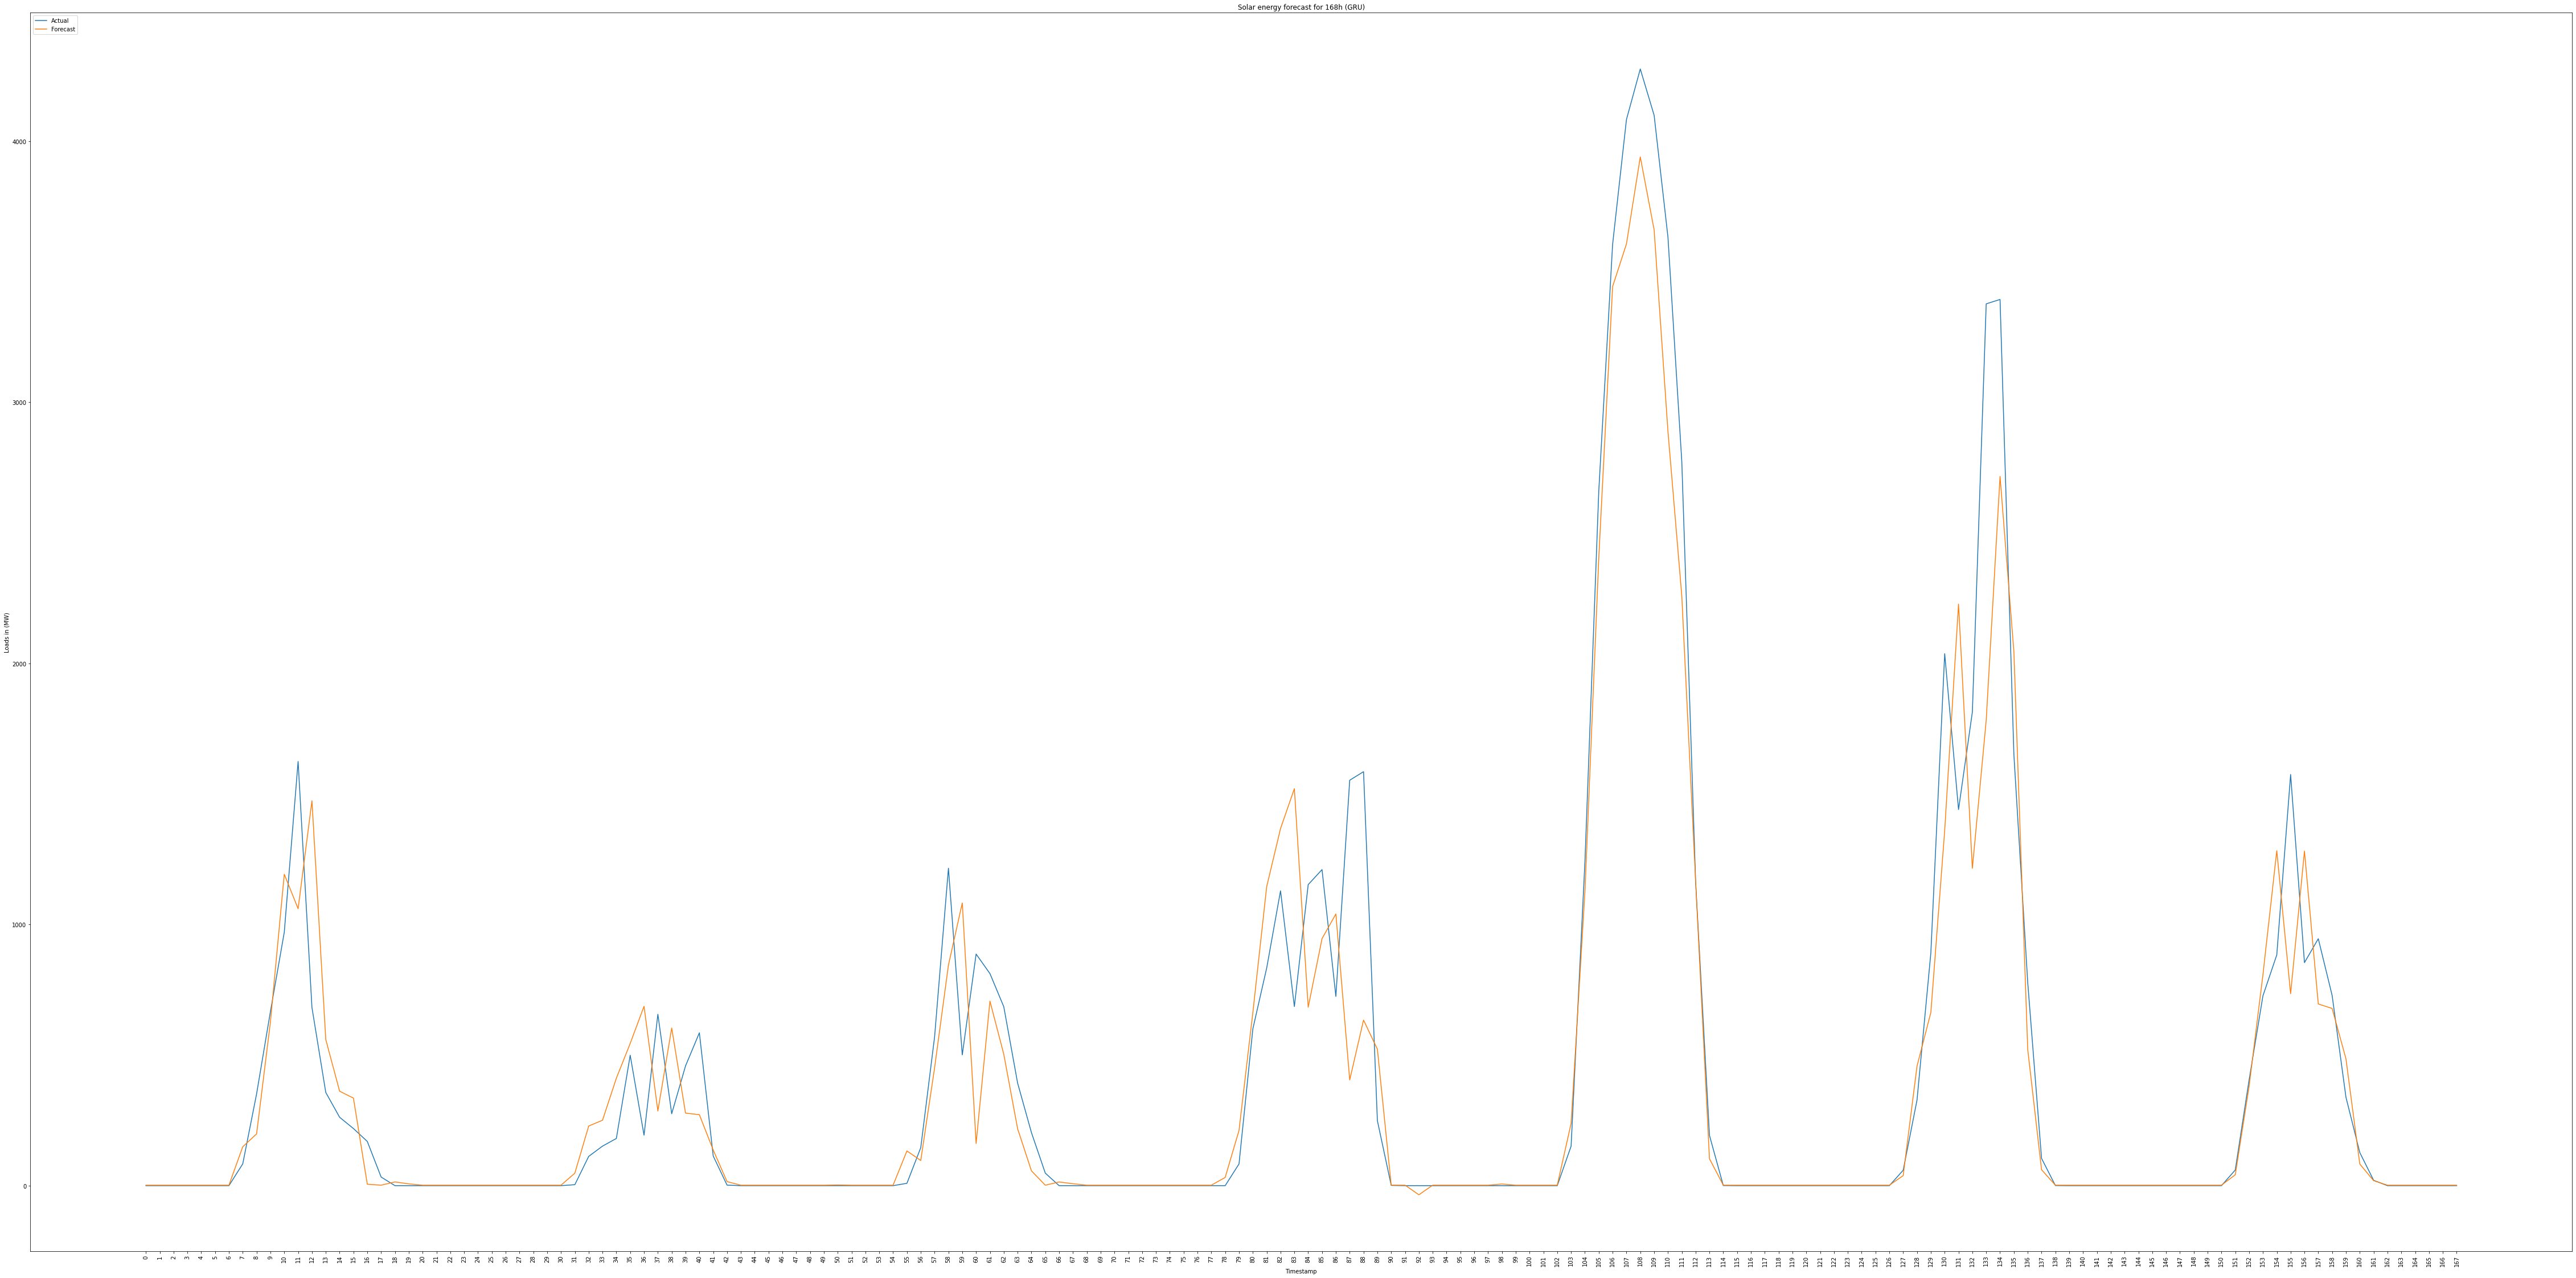

In [38]:
forecast = multivariate_gru.predict(X_test[-168:])
gru_forecast = scaler_y.inverse_transform(forecast)


x = []
for i in range(168):
  x.append(str(i))

plt.figure(figsize=(80, 40))
plt.plot(x,scaler_y.inverse_transform(y_test[-168:]), label="Actual")
plt.plot(x,gru_forecast, label="Forecast")

plt.legend(loc="upper left")

plt.xticks(x)
plt.xlabel('Timestamp')
plt.ylabel('Loads in (MW)')
plt.title('Solar energy forecast for 168h (GRU)')
plt.xticks(rotation = 90)
plt.savefig('/content/files_DL/gru_forecast_actual.png', fontsize=50)
plt.show()

In [39]:
multivariate_gru = tf.keras.models.load_model('/content/models/multivariate_gru.h5',
              custom_objects={'root_mean_squared_error':root_mean_squared_error})

forecast = multivariate_gru.predict(X_test)
gru_forecast = scaler_y.inverse_transform(forecast)

rmse_gru = sqrt(mean_squared_error(y_test,
                                    forecast))
print('RMSE (Normalized ) of GRU forecast: {}'
      .format(round(rmse_gru, 8)))

rmse_gru = sqrt(mean_squared_error(y_test_inv,
                                    gru_forecast))
print('RMSE of GRU forecast: {}'
      .format(round(rmse_gru, 4)))

mae_gru_n = mean_absolute_error(y_test,
                                    forecast)
print('MAE (Normalized) of GRU forecast: {}'
      .format(round(mae_gru_n, 8)))

mae_gru = mean_absolute_error(y_test_inv,
                                    gru_forecast)
print('MAE of GRU forecast: {}'
      .format(round(mae_gru, 4)))

RMSE (Normalized ) of GRU forecast: 0.05902493
RMSE of GRU forecast: 278.7748
MAE (Normalized) of GRU forecast: 0.02841625
MAE of GRU forecast: 134.21


# **CNN**

In [40]:
tf.keras.backend.clear_session()

multivariate_cnn = tf.keras.models.Sequential([
    Conv1D(filters=48, kernel_size=2,
           strides=1, padding='causal',
           activation='relu', 
           input_shape=input_shape),
    Flatten(),
    Dense(48, activation='relu'),
    Dense(1)
])

optimizer = tf.keras.optimizers.Adam(lr=1e-4, amsgrad=True)

multivariate_cnn.compile(loss=loss,
                          optimizer=optimizer,
                          metrics=metric)

In [41]:
history_lr = multivariate_cnn.fit(train, epochs=50,
                               validation_data=validation,
                               callbacks=[lr_schedule])

Epoch 1/50
71/71 [==============================] - 8s 7ms/step - loss: 0.1730 - mse: 0.0596 - mae: 0.1730 - val_loss: 0.1454 - val_mse: 0.0445 - val_mae: 0.1454 - lr: 1.0000e-04
Epoch 2/50
71/71 [==============================] - 0s 5ms/step - loss: 0.1074 - mse: 0.0232 - mae: 0.1074 - val_loss: 0.1154 - val_mse: 0.0271 - val_mae: 0.1154 - lr: 1.2589e-04
Epoch 3/50
71/71 [==============================] - 0s 5ms/step - loss: 0.0883 - mse: 0.0175 - mae: 0.0883 - val_loss: 0.0984 - val_mse: 0.0210 - val_mae: 0.0984 - lr: 1.5849e-04
Epoch 4/50
71/71 [==============================] - 0s 5ms/step - loss: 0.0785 - mse: 0.0145 - mae: 0.0785 - val_loss: 0.0850 - val_mse: 0.0167 - val_mae: 0.0850 - lr: 1.9953e-04
Epoch 5/50
71/71 [==============================] - 0s 5ms/step - loss: 0.0712 - mse: 0.0124 - mae: 0.0712 - val_loss: 0.0803 - val_mse: 0.0146 - val_mae: 0.0803 - lr: 2.5119e-04
Epoch 6/50
71/71 [==============================] - 0s 5ms/step - loss: 0.0657 - mse: 0.0106 - mae: 0.065

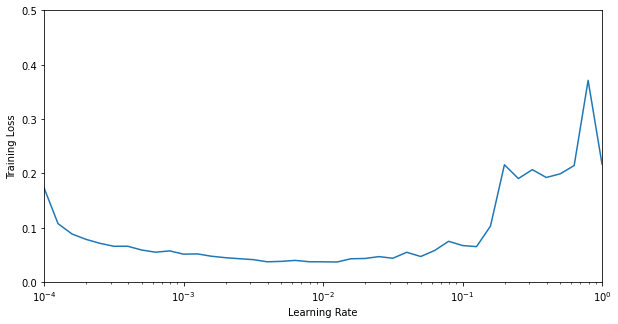

In [42]:
name = '/content/files_DL/cnn_history_lr.png'
plot_learning_rate_schedule(history_lr, 0.5, name)

In [43]:
tf.keras.backend.clear_session()

multivariate_cnn = tf.keras.models.Sequential([
    Conv1D(filters=48, kernel_size=2,
           strides=1, padding='causal',
           activation='relu', 
           input_shape=input_shape),
    Flatten(),
    Dense(48, activation='relu'),
    Dense(1)
])

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
                   '/content/models/multivariate_cnn.h5', monitor=('val_loss'), save_best_only=True)
optimizer = tf.keras.optimizers.Adam(lr=0.002, amsgrad=True)

multivariate_cnn.compile(loss=loss,
                          optimizer=optimizer,
                          metrics=metric)

multivariate_cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 30, 48)            1008      
                                                                 
 flatten (Flatten)           (None, 1440)              0         
                                                                 
 dense (Dense)               (None, 48)                69168     
                                                                 
 dense_1 (Dense)             (None, 1)                 49        
                                                                 
Total params: 70,225
Trainable params: 70,225
Non-trainable params: 0
_________________________________________________________________


In [44]:
history = multivariate_cnn.fit(train, epochs=1000,
                                validation_data=validation,
                                callbacks=[early_stopping,model_checkpoint])

Epoch 1/1000
71/71 [==============================] - 1s 13ms/step - loss: 0.1444 - mse: 0.0690 - mae: 0.1444 - val_loss: 0.0818 - val_mse: 0.0191 - val_mae: 0.0818
Epoch 2/1000
71/71 [==============================] - 0s 5ms/step - loss: 0.0646 - mse: 0.0125 - mae: 0.0646 - val_loss: 0.0720 - val_mse: 0.0148 - val_mae: 0.0720
Epoch 3/1000
71/71 [==============================] - 0s 5ms/step - loss: 0.0537 - mse: 0.0087 - mae: 0.0537 - val_loss: 0.0679 - val_mse: 0.0125 - val_mae: 0.0679
Epoch 4/1000
71/71 [==============================] - 0s 5ms/step - loss: 0.0467 - mse: 0.0071 - mae: 0.0467 - val_loss: 0.0569 - val_mse: 0.0095 - val_mae: 0.0569
Epoch 5/1000
71/71 [==============================] - 0s 5ms/step - loss: 0.0427 - mse: 0.0061 - mae: 0.0427 - val_loss: 0.0554 - val_mse: 0.0090 - val_mae: 0.0554
Epoch 6/1000
71/71 [==============================] - 0s 5ms/step - loss: 0.0407 - mse: 0.0056 - mae: 0.0407 - val_loss: 0.0481 - val_mse: 0.0073 - val_mae: 0.0481
Epoch 7/1000
71

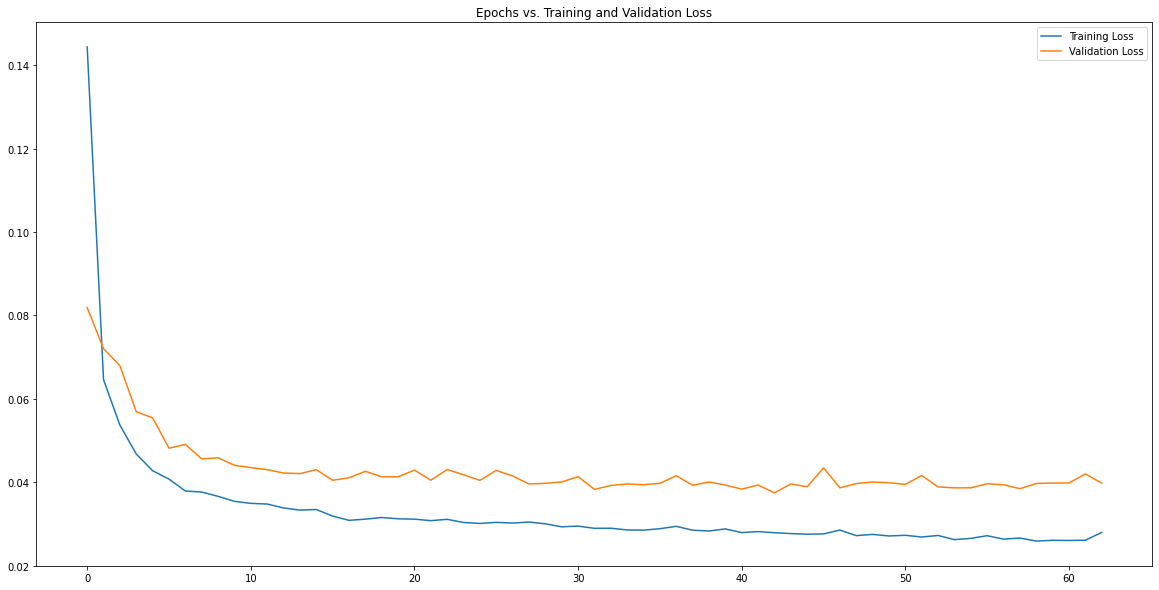

In [45]:
name = '/content/files_DL/cnn.png'
plot_model_loss(history, name)

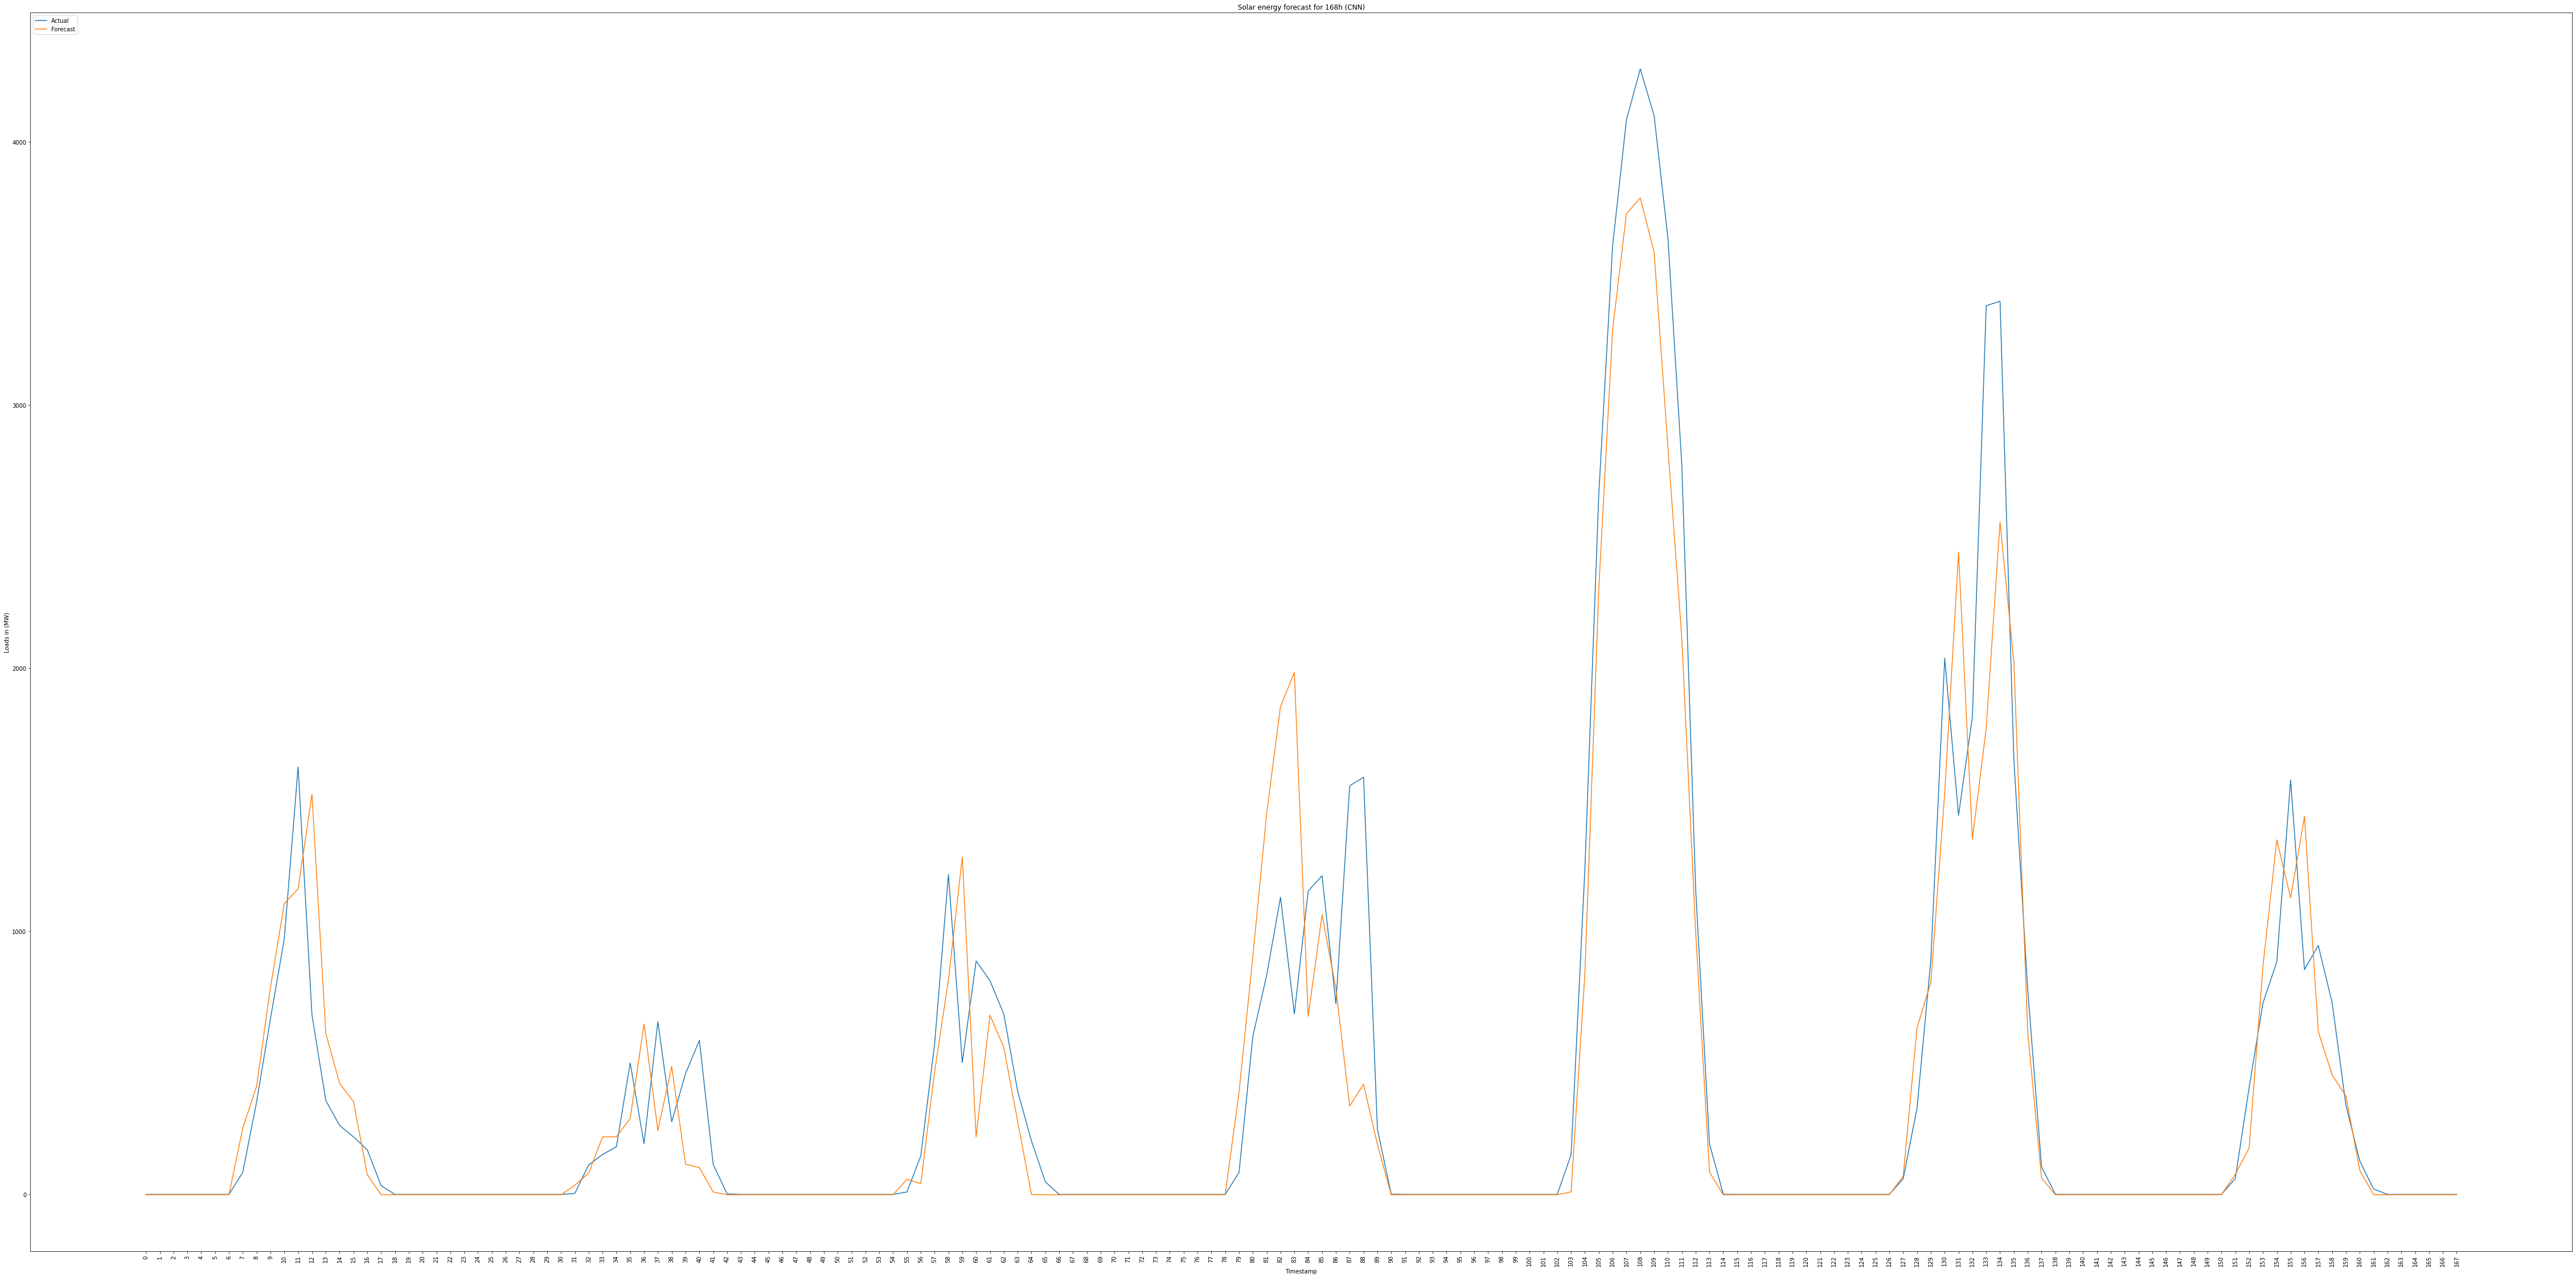

In [46]:
forecast = multivariate_cnn.predict(X_test[-168:])
cnn_forecast = scaler_y.inverse_transform(forecast)


x = []
for i in range(168):
  x.append(str(i))

plt.figure(figsize=(80, 40))
plt.plot(x,scaler_y.inverse_transform(y_test[-168:]), label="Actual")
plt.plot(x,cnn_forecast, label="Forecast")

plt.legend(loc="upper left")

plt.xticks(x)
plt.xlabel('Timestamp')
plt.ylabel('Loads in (MW)')
plt.title('Solar energy forecast for 168h (CNN)')
plt.xticks(rotation = 90)
plt.savefig('/content/files_DL/cnn_forecast_actual.png', fontsize=50)
plt.show()

In [47]:
multivariate_cnn = tf.keras.models.load_model('/content/models/multivariate_cnn.h5',
              custom_objects={'root_mean_squared_error':root_mean_squared_error})

forecast = multivariate_cnn.predict(X_test)
cnn_forecast = scaler_y.inverse_transform(forecast)

rmse_cnn_n = sqrt(mean_squared_error(y_test,
                                    forecast))
print('RMSE (Normalized) of CNN forecast: {}'
      .format(round(rmse_cnn_n, 8)))

rmse_cnn = sqrt(mean_squared_error(y_test_inv,
                                    cnn_forecast))
print('RMSE of CNN forecast: {}'
      .format(round(rmse_cnn, 4)))

mae_cnn_n = mean_absolute_error(y_test,
                                    forecast)
print('MAE (Normalized) of CNN forecast: {}'
      .format(round(mae_cnn_n, 8)))

mae_cnn = mean_absolute_error(y_test_inv,
                                    cnn_forecast)
print('MAE of CNN forecast: {}'
      .format(round(mae_cnn, 4)))

RMSE (Normalized) of CNN forecast: 0.05945208
RMSE of CNN forecast: 280.7922
MAE (Normalized) of CNN forecast: 0.02811846
MAE of CNN forecast: 132.8035


# **Stacked LSTM**

In [48]:
tf.keras.backend.clear_session()

multivariate_stacked_lstm = tf.keras.models.Sequential([
    LSTM(250, input_shape=input_shape, 
         return_sequences=True),
    LSTM(150, return_sequences=True),
    Flatten(),
    Dense(150, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

optimizer = tf.keras.optimizers.Adam(lr=1e-4, amsgrad=True)

multivariate_stacked_lstm.compile(loss=loss,
                                  optimizer=optimizer,
                                  metrics=metric)

In [49]:
history_lr = multivariate_stacked_lstm.fit(train, epochs=50,
                                validation_data=validation,
                                callbacks=[lr_schedule])

Epoch 1/50
71/71 [==============================] - 4s 24ms/step - loss: 0.1408 - mse: 0.0485 - mae: 0.1408 - val_loss: 0.1351 - val_mse: 0.0529 - val_mae: 0.1351 - lr: 1.0000e-04
Epoch 2/50
71/71 [==============================] - 1s 13ms/step - loss: 0.0908 - mse: 0.0259 - mae: 0.0908 - val_loss: 0.0913 - val_mse: 0.0276 - val_mae: 0.0913 - lr: 1.2589e-04
Epoch 3/50
71/71 [==============================] - 1s 12ms/step - loss: 0.0749 - mse: 0.0201 - mae: 0.0749 - val_loss: 0.0858 - val_mse: 0.0258 - val_mae: 0.0858 - lr: 1.5849e-04
Epoch 4/50
71/71 [==============================] - 1s 12ms/step - loss: 0.0683 - mse: 0.0176 - mae: 0.0683 - val_loss: 0.0808 - val_mse: 0.0228 - val_mae: 0.0808 - lr: 1.9953e-04
Epoch 5/50
71/71 [==============================] - 1s 12ms/step - loss: 0.0651 - mse: 0.0160 - mae: 0.0651 - val_loss: 0.0803 - val_mse: 0.0225 - val_mae: 0.0803 - lr: 2.5119e-04
Epoch 6/50
71/71 [==============================] - 1s 12ms/step - loss: 0.0622 - mse: 0.0147 - mae:

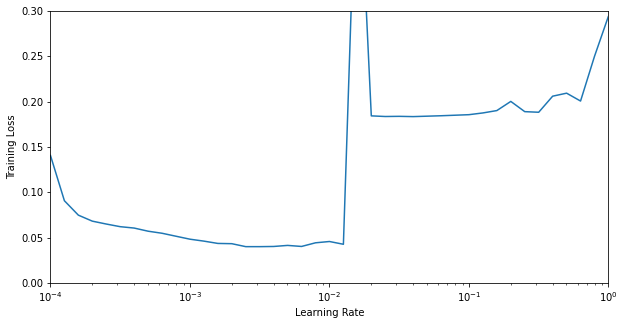

In [50]:
name = '/content/files_DL/stacked_lstm_history_lr.png'
plot_learning_rate_schedule(history_lr, 0.3, name)

In [51]:
tf.keras.backend.clear_session()

multivariate_stacked_lstm = tf.keras.models.Sequential([
    LSTM(250, input_shape=input_shape, 
         return_sequences=True),
    LSTM(150, return_sequences=True),
    Flatten(),
    Dense(150, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
                   '/content/models/multivariate_stacked_lstm.h5', save_best_only=True)

optimizer = tf.keras.optimizers.Adam(lr=0.002, amsgrad=True)

multivariate_stacked_lstm.compile(loss=loss,
                                  optimizer=optimizer,
                                  metrics=metric)

multivariate_stacked_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 250)           261000    
                                                                 
 lstm_1 (LSTM)               (None, 30, 150)           240600    
                                                                 
 flatten (Flatten)           (None, 4500)              0         
                                                                 
 dense (Dense)               (None, 150)               675150    
                                                                 
 dropout (Dropout)           (None, 150)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 151       
                                                                 
Total params: 1,176,901
Trainable params: 1,176,901
Non-

In [52]:
history = multivariate_stacked_lstm.fit(train, epochs=1000,
                                validation_data=validation,
                                callbacks=[early_stopping, 
                                           model_checkpoint])

Epoch 1/1000
71/71 [==============================] - 4s 24ms/step - loss: 0.1706 - mse: 0.1537 - mae: 0.1706 - val_loss: 0.0966 - val_mse: 0.0323 - val_mae: 0.0966
Epoch 2/1000
71/71 [==============================] - 1s 13ms/step - loss: 0.0842 - mse: 0.0267 - mae: 0.0842 - val_loss: 0.0887 - val_mse: 0.0273 - val_mae: 0.0887
Epoch 3/1000
71/71 [==============================] - 1s 12ms/step - loss: 0.0759 - mse: 0.0215 - mae: 0.0759 - val_loss: 0.0922 - val_mse: 0.0280 - val_mae: 0.0922
Epoch 4/1000
71/71 [==============================] - 1s 13ms/step - loss: 0.0718 - mse: 0.0193 - mae: 0.0718 - val_loss: 0.0792 - val_mse: 0.0213 - val_mae: 0.0792
Epoch 5/1000
71/71 [==============================] - 1s 13ms/step - loss: 0.0656 - mse: 0.0160 - mae: 0.0656 - val_loss: 0.0739 - val_mse: 0.0178 - val_mae: 0.0739
Epoch 6/1000
71/71 [==============================] - 1s 14ms/step - loss: 0.0599 - mse: 0.0137 - mae: 0.0599 - val_loss: 0.0662 - val_mse: 0.0136 - val_mae: 0.0662
Epoch 7/10

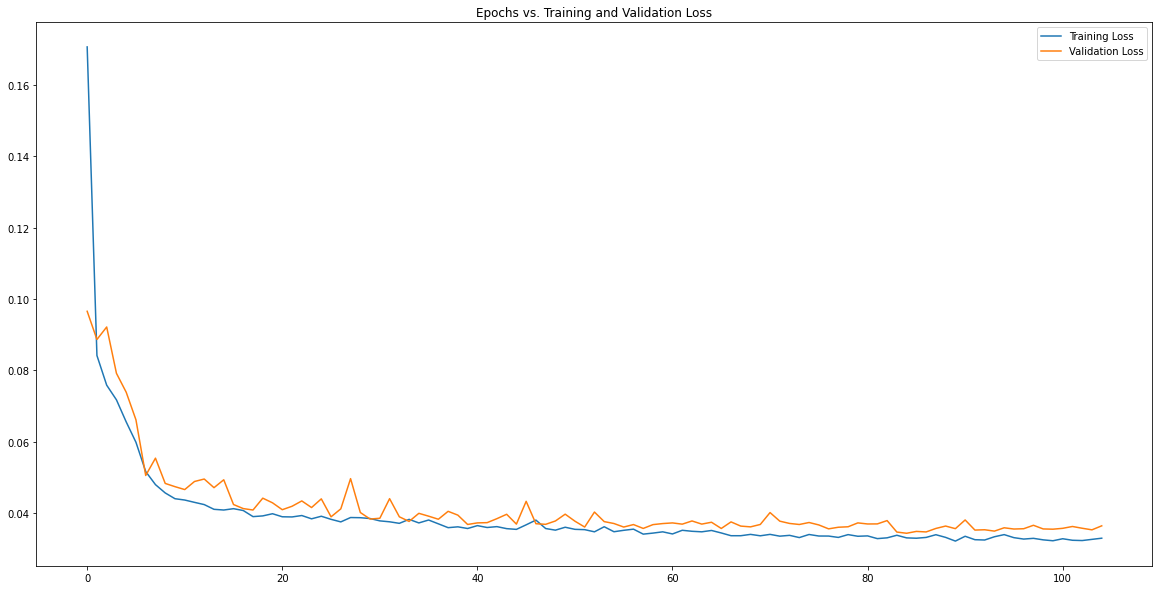

In [53]:
name = '/content/files_DL/stacked_lstm.png'
plot_model_loss(history, name)

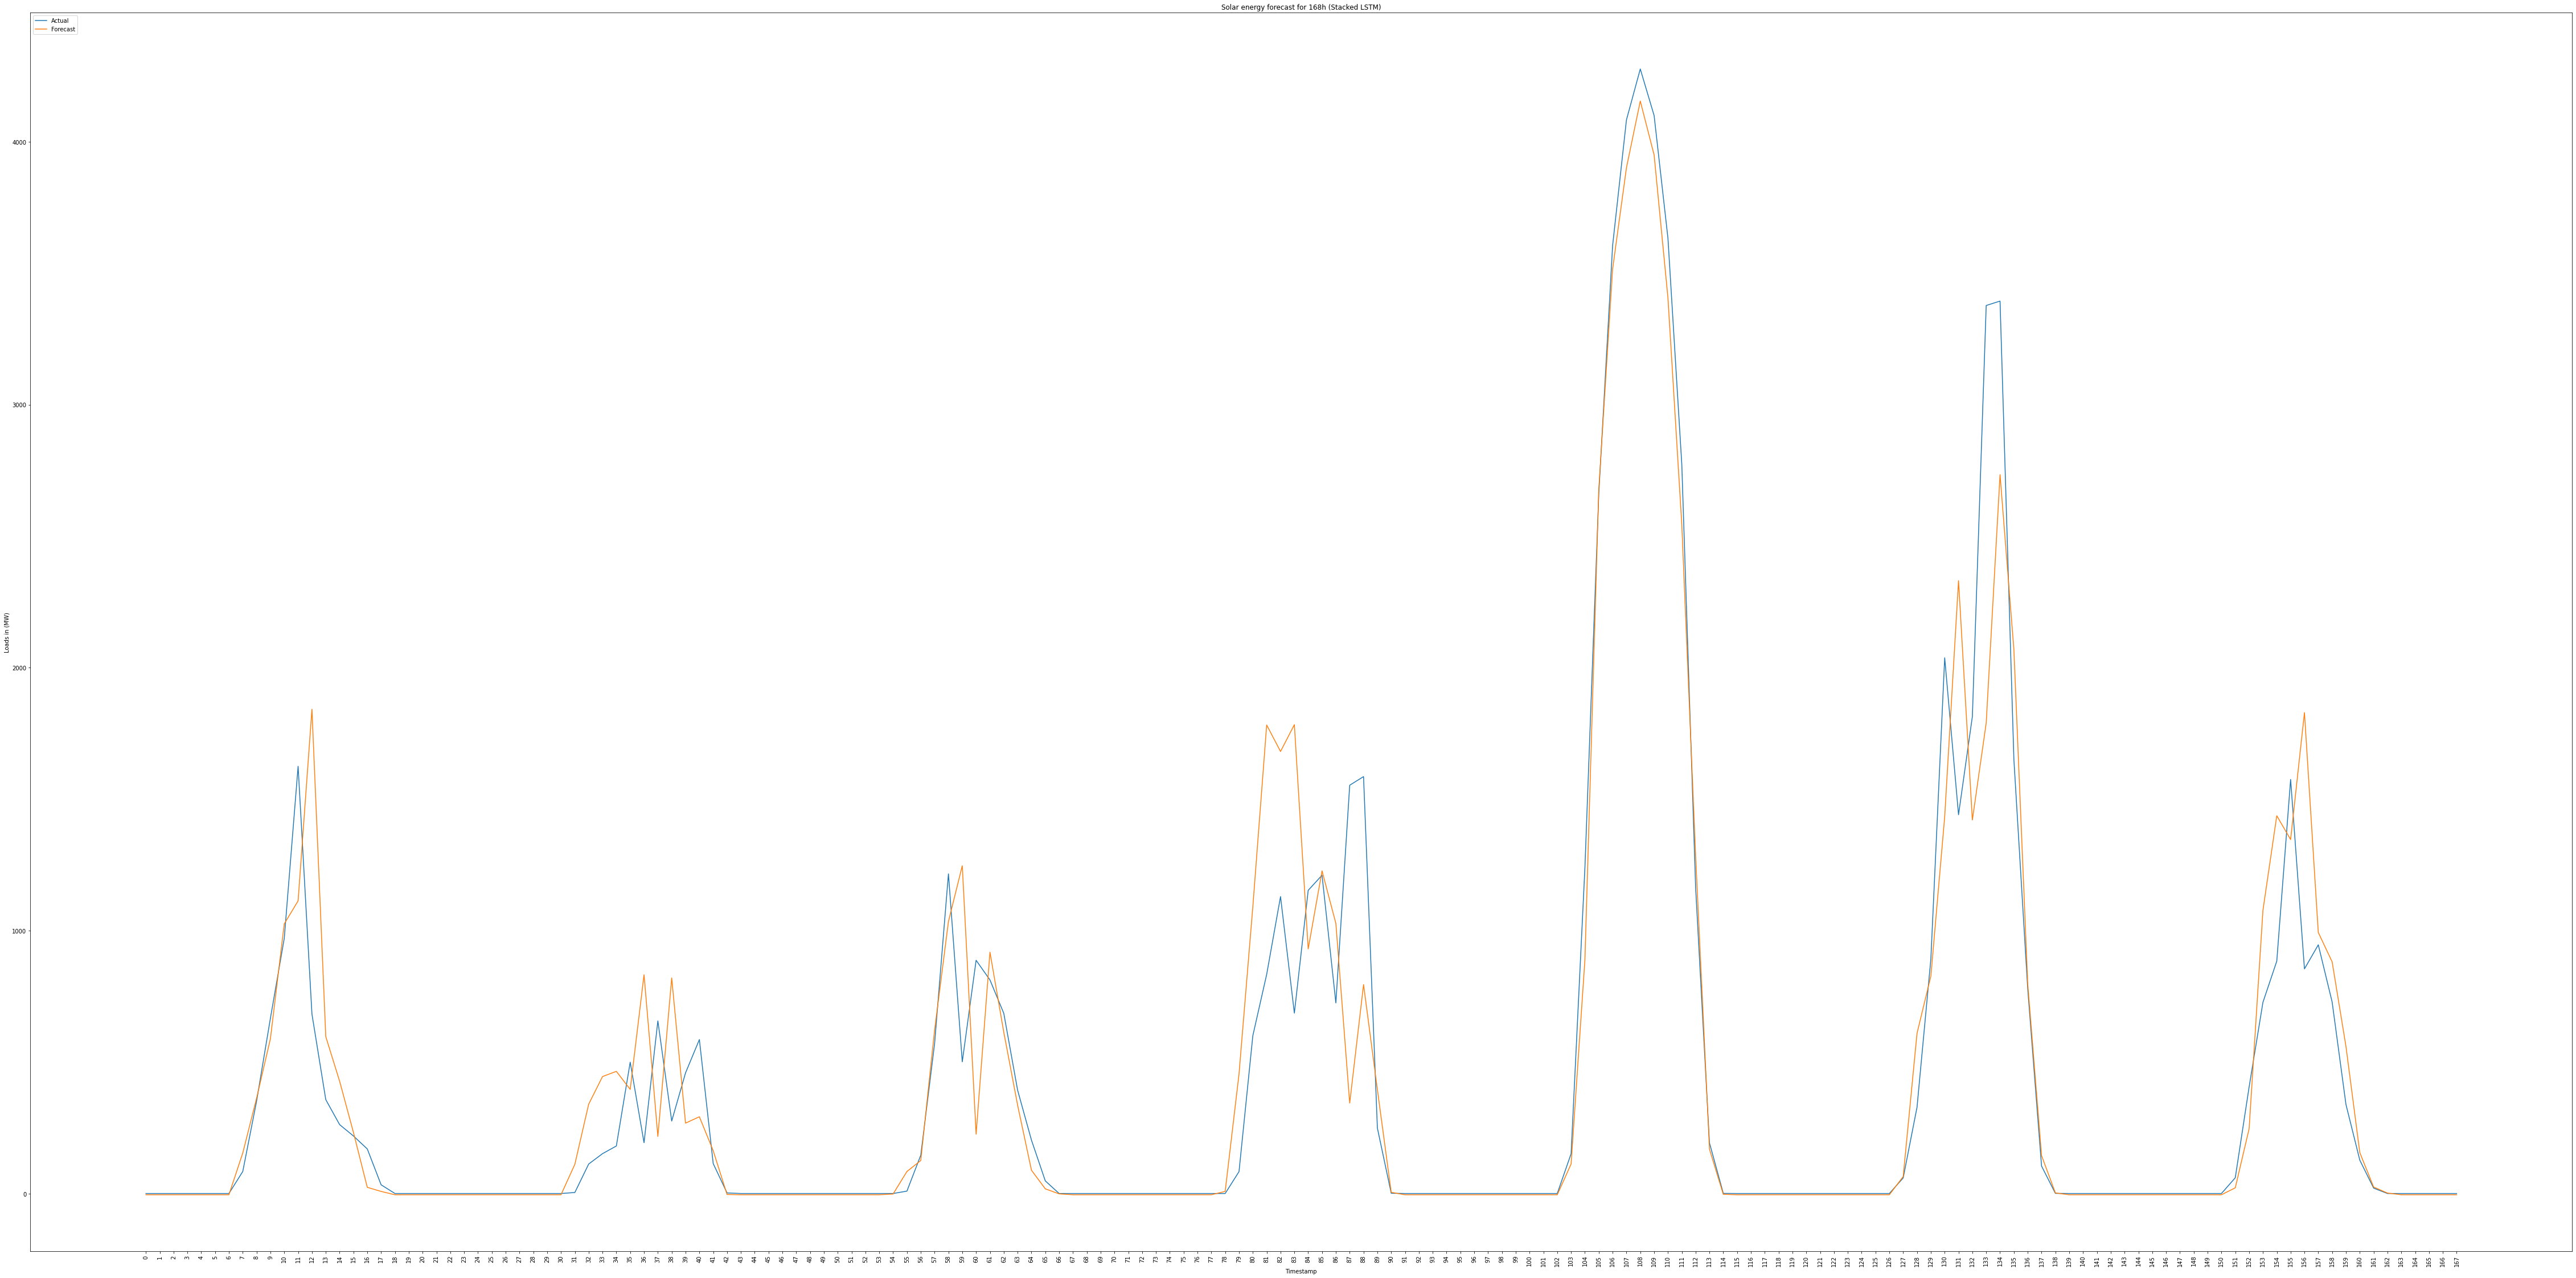

In [54]:
forecast = multivariate_stacked_lstm.predict(X_test[-168:])
stacked_lstm_forecast = scaler_y.inverse_transform(forecast)


x = []
for i in range(168):
  x.append(str(i))

plt.figure(figsize=(80, 40))
plt.plot(x,scaler_y.inverse_transform(y_test[-168:]), label="Actual")
plt.plot(x,stacked_lstm_forecast, label="Forecast")

plt.legend(loc="upper left")

plt.xticks(x)
plt.xlabel('Timestamp')
plt.ylabel('Loads in (MW)')
plt.title('Solar energy forecast for 168h (Stacked LSTM)')
plt.xticks(rotation = 90)
plt.savefig('/content/files_DL/stacked_lstm_forecast_actual.png', fontsize=50)
plt.show()

In [55]:
multivariate_stacked_lstm = tf.keras.models.load_model('/content/models/multivariate_stacked_lstm.h5',
              custom_objects={'root_mean_squared_error':root_mean_squared_error})

forecast = multivariate_stacked_lstm.predict(X_test)
stacked_lstm_forecast = scaler_y.inverse_transform(forecast)

rmse_stacked_lstm = sqrt(mean_squared_error(y_test,
                                    forecast))
print('RMSE (Normalized ) of Stacked LSTM forecast: {}'
      .format(round(rmse_stacked_lstm, 6)))

rmse_stacked_lstm = sqrt(mean_squared_error(y_test_inv,
                                    stacked_lstm_forecast))
print('RMSE of Stacked LSTM forecast: {}'
      .format(round(rmse_stacked_lstm, 6)))

mae_stacked_lstm_n = mean_absolute_error(y_test,
                                    forecast)
print('MAE (Normalized) of Stacked LSTM forecast: {}'
      .format(round(mae_stacked_lstm_n, 8)))

mae_stacked_lstm = mean_absolute_error(y_test_inv,
                                    stacked_lstm_forecast)
print('MAE of Stacked LSTM forecast: {}'
      .format(round(mae_stacked_lstm, 4)))

RMSE (Normalized ) of Stacked LSTM forecast: 0.058515
RMSE of Stacked LSTM forecast: 276.367353
MAE (Normalized) of Stacked LSTM forecast: 0.02765388
MAE of Stacked LSTM forecast: 130.6093


# **LSTM Autoencoder**

In [56]:
tf.keras.backend.clear_session()

encoder_decoder = tf.keras.models.Sequential([
    LSTM(64, activation='relu', input_shape=input_shape),
    RepeatVector(past_history),
    LSTM(64, activation='relu', return_sequences=True),
    TimeDistributed(Dense(64, activation='relu')),
    Flatten(),
    Dense(32, activation='relu'),
    Dropout(0.20),
    Dense(1)
])


optimizer = tf.keras.optimizers.Adam(lr=1e-4, amsgrad=True)

encoder_decoder.compile(loss=loss,
                    optimizer=optimizer,
                    metrics=metric)

In [57]:
history_lr = encoder_decoder.fit(train, epochs=50,
                              validation_data=validation,
                              callbacks=[lr_schedule])

Epoch 1/50
71/71 [==============================] - 10s 111ms/step - loss: 0.1657 - mse: 0.0805 - mae: 0.1657 - val_loss: 0.1507 - val_mse: 0.0660 - val_mae: 0.1507 - lr: 1.0000e-04
Epoch 2/50
71/71 [==============================] - 8s 106ms/step - loss: 0.1023 - mse: 0.0301 - mae: 0.1023 - val_loss: 0.0775 - val_mse: 0.0198 - val_mae: 0.0775 - lr: 1.2589e-04
Epoch 3/50
71/71 [==============================] - 8s 107ms/step - loss: 0.0620 - mse: 0.0141 - mae: 0.0620 - val_loss: 0.0702 - val_mse: 0.0155 - val_mae: 0.0702 - lr: 1.5849e-04
Epoch 4/50
71/71 [==============================] - 8s 108ms/step - loss: 0.0580 - mse: 0.0125 - mae: 0.0580 - val_loss: 0.0709 - val_mse: 0.0153 - val_mae: 0.0709 - lr: 1.9953e-04
Epoch 5/50
71/71 [==============================] - 8s 107ms/step - loss: 0.0529 - mse: 0.0109 - mae: 0.0529 - val_loss: 0.0612 - val_mse: 0.0120 - val_mae: 0.0612 - lr: 2.5119e-04
Epoch 6/50
71/71 [==============================] - 8s 108ms/step - loss: 0.0501 - mse: 0.0099

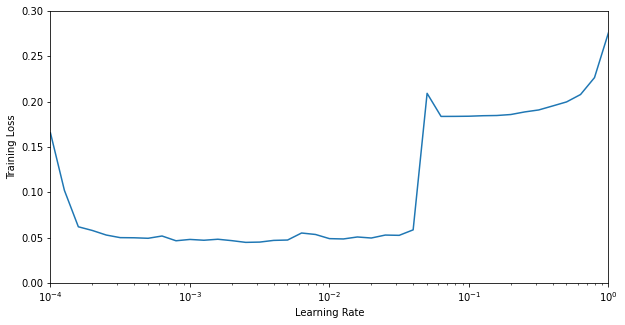

In [58]:
name = '/content/files_DL/encoder_decoder_history_lr.png'
plot_learning_rate_schedule(history_lr, 0.3, name)

In [59]:
tf.keras.backend.clear_session()

encoder_decoder = tf.keras.models.Sequential([
    LSTM(64, activation='relu', input_shape=input_shape),
    RepeatVector(past_history),
    LSTM(64, activation='relu', return_sequences=True),
    TimeDistributed(Dense(64, activation='relu')),
    Flatten(),
    Dense(32, activation='relu'),
    Dropout(0.20),
    Dense(1)
])

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
                   '/content/models/encoder_decoder.h5', save_best_only=True)

optimizer = tf.keras.optimizers.Adam(lr=1e-3, amsgrad=True)

encoder_decoder.compile(loss=loss,
                    optimizer=optimizer,
                    metrics=metric)

encoder_decoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                19200     
                                                                 
 repeat_vector (RepeatVector  (None, 30, 64)           0         
 )                                                               
                                                                 
 lstm_1 (LSTM)               (None, 30, 64)            33024     
                                                                 
 time_distributed (TimeDistr  (None, 30, 64)           4160      
 ibuted)                                                         
                                                                 
 flatten (Flatten)           (None, 1920)              0         
                                                                 
 dense_1 (Dense)             (None, 32)                6

In [60]:
history = encoder_decoder.fit(train, epochs=1000,
                              validation_data=validation,
                              callbacks=[early_stopping, 
                                         model_checkpoint])

Epoch 1/1000
71/71 [==============================] - 10s 108ms/step - loss: 0.0934 - mse: 0.0325 - mae: 0.0934 - val_loss: 0.0896 - val_mse: 0.0236 - val_mae: 0.0896
Epoch 2/1000
71/71 [==============================] - 7s 105ms/step - loss: 0.0609 - mse: 0.0134 - mae: 0.0609 - val_loss: 0.0722 - val_mse: 0.0154 - val_mae: 0.0722
Epoch 3/1000
71/71 [==============================] - 7s 102ms/step - loss: 0.0498 - mse: 0.0094 - mae: 0.0498 - val_loss: 0.0676 - val_mse: 0.0135 - val_mae: 0.0676
Epoch 4/1000
71/71 [==============================] - 7s 102ms/step - loss: 0.0466 - mse: 0.0085 - mae: 0.0466 - val_loss: 0.0543 - val_mse: 0.0096 - val_mae: 0.0543
Epoch 5/1000
71/71 [==============================] - 8s 106ms/step - loss: 0.0496 - mse: 0.0095 - mae: 0.0496 - val_loss: 0.0558 - val_mse: 0.0098 - val_mae: 0.0558
Epoch 6/1000
71/71 [==============================] - 8s 113ms/step - loss: 0.0450 - mse: 0.0082 - mae: 0.0450 - val_loss: 0.0607 - val_mse: 0.0115 - val_mae: 0.0607
Epo

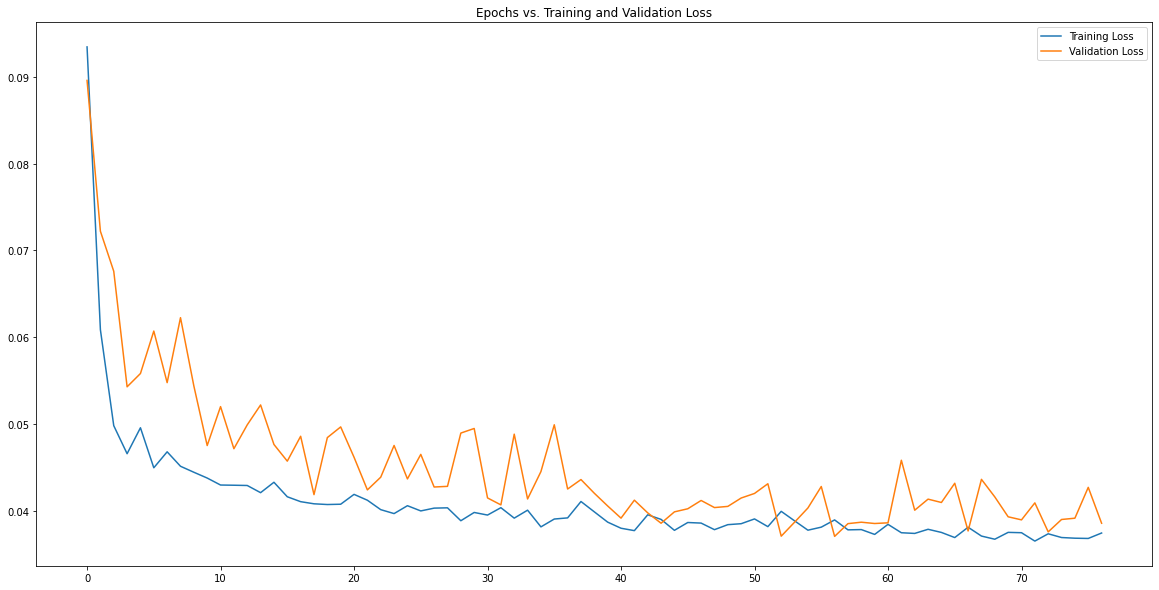

In [61]:
name = '/content/files_DL/encoder_decoder.png'
plot_model_loss(history, name)

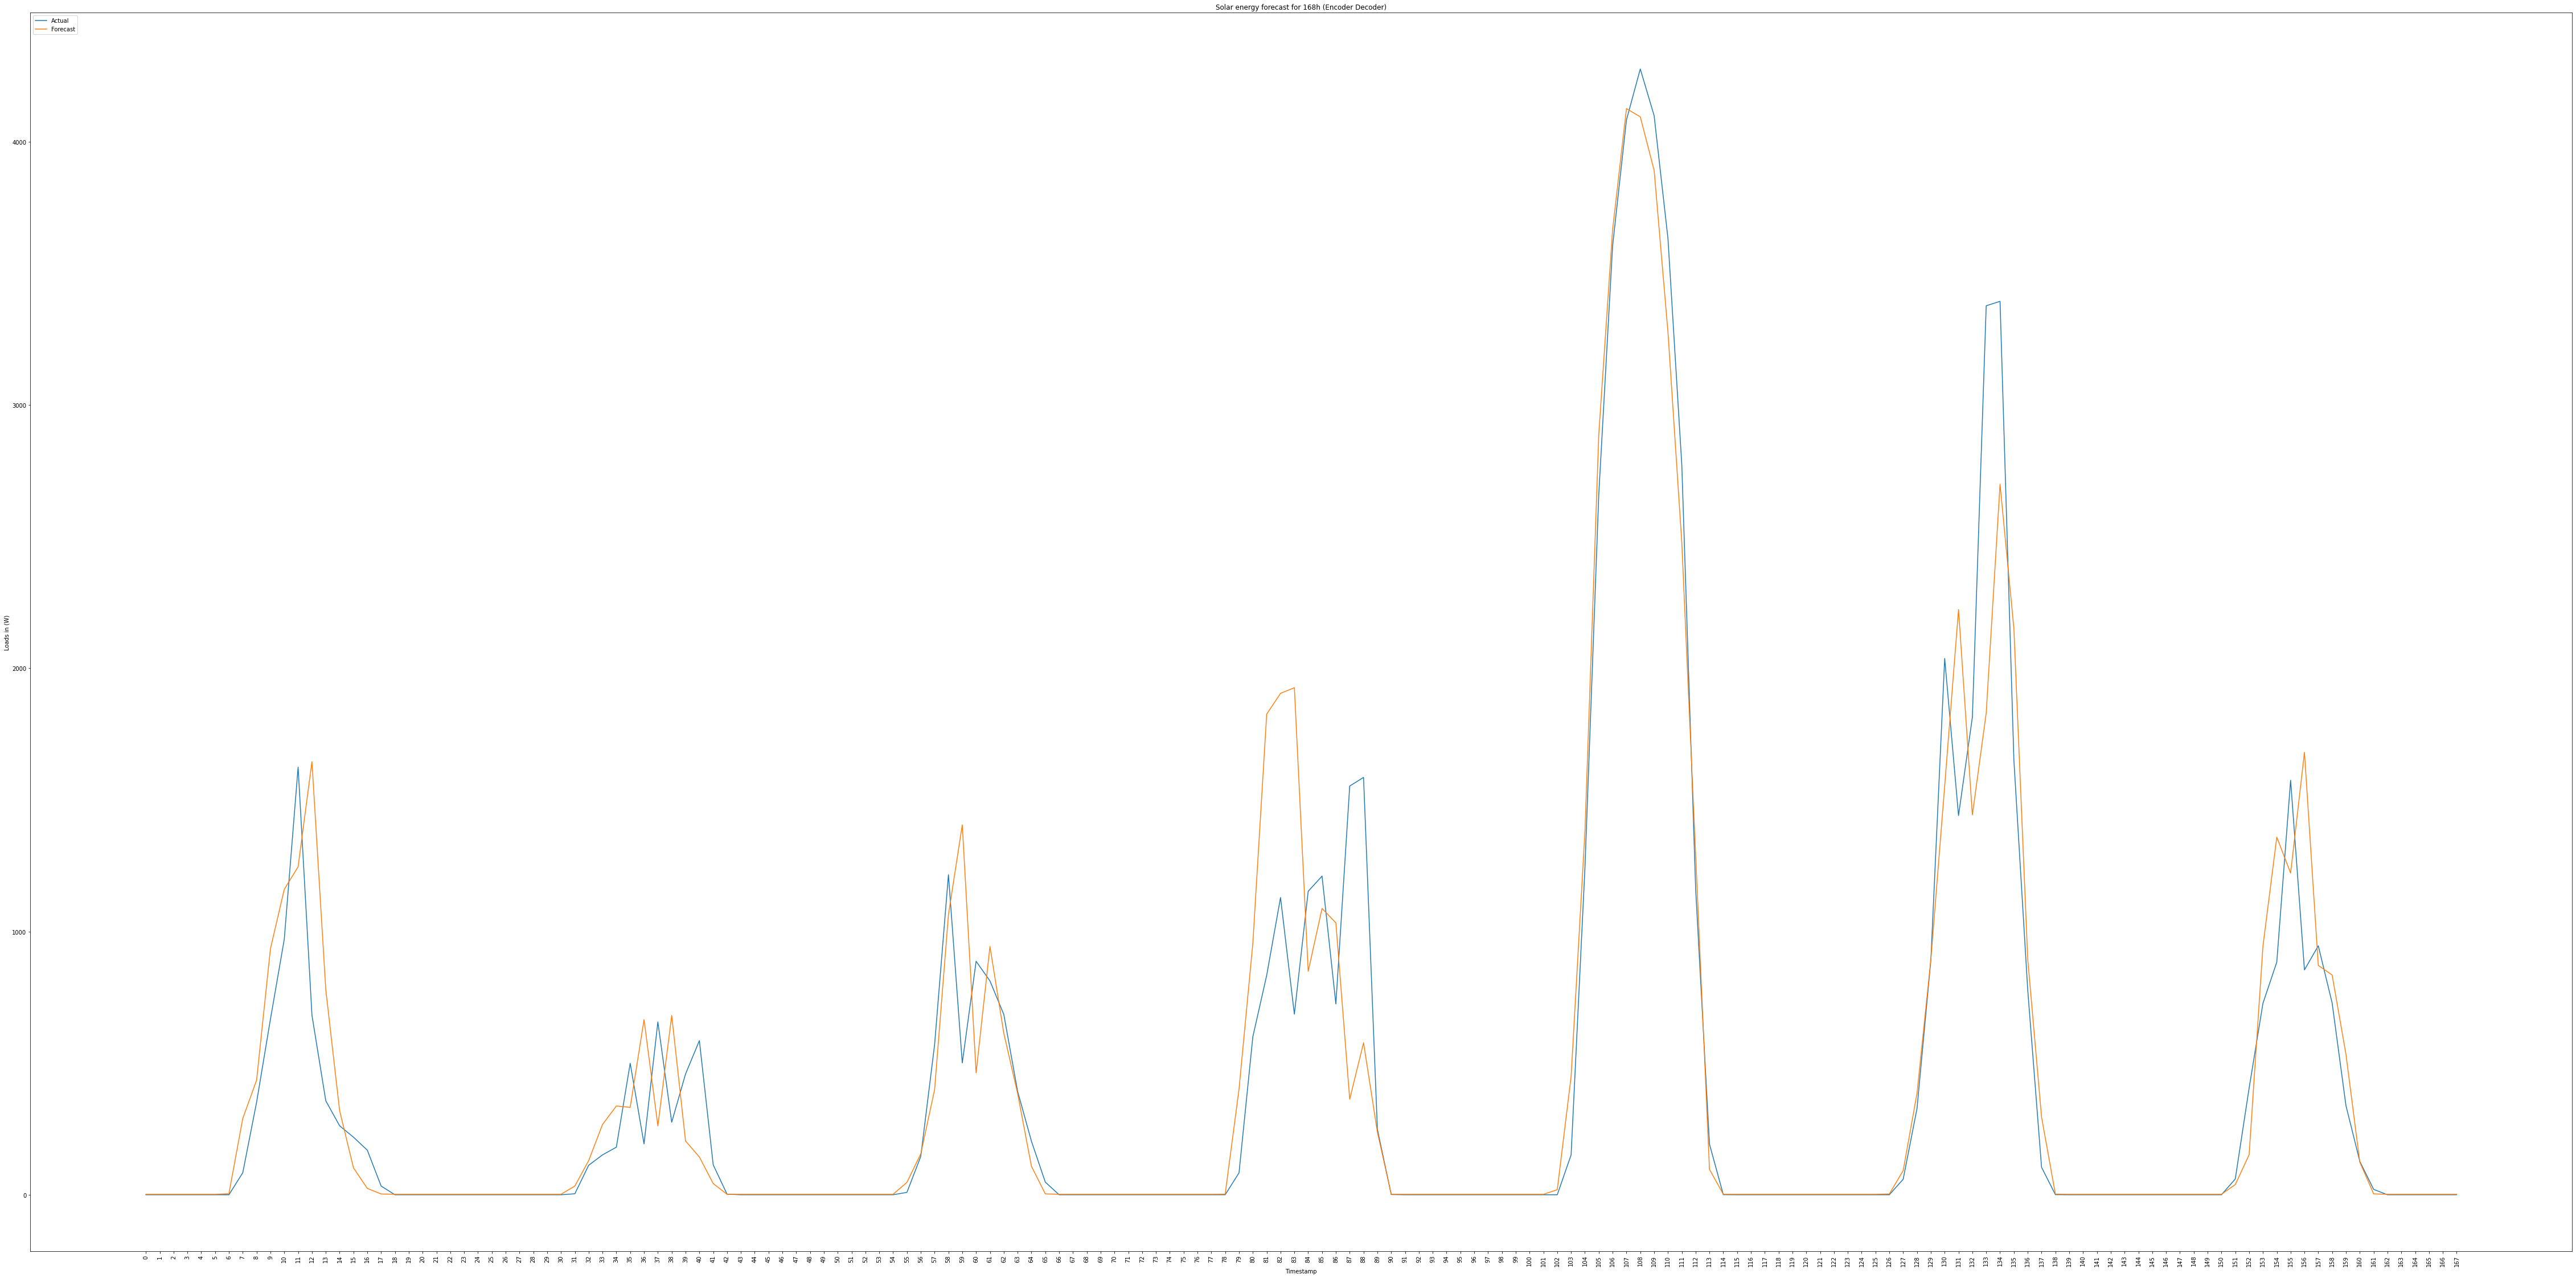

In [62]:
forecast = encoder_decoder.predict(X_test[-168:])
encoder_decoder_forecast = scaler_y.inverse_transform(forecast)


x = []
for i in range(168):
  x.append(str(i))

plt.figure(figsize=(80, 40))
plt.plot(x,scaler_y.inverse_transform(y_test[-168:]), label="Actual")
plt.plot(x,encoder_decoder_forecast, label="Forecast")

plt.legend(loc="upper left")

plt.xticks(x)
plt.xlabel('Timestamp')
plt.ylabel('Loads in (W)')
plt.title('Solar energy forecast for 168h (Encoder Decoder)')
plt.xticks(rotation = 90)
plt.savefig('/content/files_DL/encoder_decoder_forecast_actual.png', fontsize=50)
plt.show()

In [63]:
encoder_decoder = tf.keras.models.load_model('/content/models/encoder_decoder.h5',
              custom_objects={'root_mean_squared_error':root_mean_squared_error})

forecast = encoder_decoder.predict(X_test)
encoder_decoder_forecast = scaler_y.inverse_transform(forecast)

rmse_encoder_decoder_n = sqrt(mean_squared_error(y_test,
                                    forecast))
print('RMSE (Normalized) of Encoder-Decoder forecast: {}'
      .format(round(rmse_encoder_decoder_n, 8)))

rmse_encoder_decoder = sqrt(mean_squared_error(y_test_inv,
                                    encoder_decoder_forecast))
print('RMSE of Encoder-Decoder forecast: {}'
      .format(round(rmse_encoder_decoder, 4)))

mae_encoder_decoder_n = mean_absolute_error(y_test,
                                    forecast)
print('MAE (Normalized) of Encoder-Decoder forecast: {}'
      .format(round(mae_encoder_decoder_n, 8)))

mae_encoder_decoder = mean_absolute_error(y_test_inv,
                                    encoder_decoder_forecast)
print('MAE of Encoder-Decoder forecast: {}'
      .format(round(mae_encoder_decoder, 4)))

RMSE (Normalized) of Encoder-Decoder forecast: 0.06161166
RMSE of Encoder-Decoder forecast: 290.9919
MAE (Normalized) of Encoder-Decoder forecast: 0.03026354
MAE of Encoder-Decoder forecast: 142.9347


# **Time Distributed MLP**

In [64]:
tf.keras.backend.clear_session()

multivariate_mlp = tf.keras.models.Sequential([
    TimeDistributed(Dense(200, activation='relu'),
                    input_shape=input_shape),
    TimeDistributed(Dense(150, activation='relu')),
    TimeDistributed(Dense(100, activation='relu')),
    TimeDistributed(Dense(50, activation='relu')),
    Flatten(),
    Dense(150, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

optimizer = tf.keras.optimizers.Adam(lr=1e-4, amsgrad=True)

multivariate_mlp.compile(loss=loss,
                          optimizer=optimizer,
                          metrics=metric)

In [65]:
history_lr = multivariate_mlp.fit(train, epochs=50,
                               validation_data=validation,
                               callbacks=[lr_schedule])

Epoch 1/50
71/71 [==============================] - 1s 7ms/step - loss: 0.1343 - mse: 0.0481 - mae: 0.1343 - val_loss: 0.1115 - val_mse: 0.0327 - val_mae: 0.1115 - lr: 1.0000e-04
Epoch 2/50
71/71 [==============================] - 0s 5ms/step - loss: 0.0805 - mse: 0.0173 - mae: 0.0805 - val_loss: 0.0752 - val_mse: 0.0161 - val_mae: 0.0752 - lr: 1.2589e-04
Epoch 3/50
71/71 [==============================] - 0s 5ms/step - loss: 0.0601 - mse: 0.0113 - mae: 0.0601 - val_loss: 0.0618 - val_mse: 0.0116 - val_mae: 0.0618 - lr: 1.5849e-04
Epoch 4/50
71/71 [==============================] - 0s 6ms/step - loss: 0.0462 - mse: 0.0078 - mae: 0.0462 - val_loss: 0.0577 - val_mse: 0.0104 - val_mae: 0.0577 - lr: 1.9953e-04
Epoch 5/50
71/71 [==============================] - 0s 5ms/step - loss: 0.0418 - mse: 0.0069 - mae: 0.0418 - val_loss: 0.0511 - val_mse: 0.0083 - val_mae: 0.0511 - lr: 2.5119e-04
Epoch 6/50
71/71 [==============================] - 0s 6ms/step - loss: 0.0409 - mse: 0.0067 - mae: 0.040

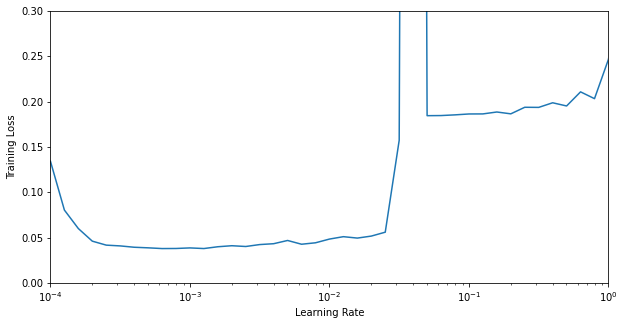

In [66]:
name = '/content/files_DL/mlp_history_lr.png'
plot_learning_rate_schedule(history_lr, 0.3, name)

In [67]:
tf.keras.backend.clear_session()

multivariate_mlp = tf.keras.models.Sequential([
    TimeDistributed(Dense(200, activation='relu'),
                    input_shape=input_shape),
    TimeDistributed(Dense(150, activation='relu')),
    TimeDistributed(Dense(100, activation='relu')),
    TimeDistributed(Dense(50, activation='relu')),
    Flatten(),
    Dense(150, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
                   '/content/models/multivariate_mlp.h5', save_best_only=True)

optimizer = tf.keras.optimizers.Adam(lr=1e-3, amsgrad=True)

multivariate_mlp.compile(loss=loss,
                          optimizer=optimizer,
                          metrics=metric)

multivariate_mlp.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 30, 200)          2200      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 30, 150)          30150     
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 30, 100)          15100     
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 30, 50)           5050      
 tributed)                                                       
                                                                 
 flatten (Flatten)           (None, 1500)              0

In [68]:
history = multivariate_mlp.fit(train, epochs=1000,
                                validation_data=validation,
                                callbacks=[early_stopping,model_checkpoint])

Epoch 1/1000
71/71 [==============================] - 2s 9ms/step - loss: 0.0864 - mse: 0.0270 - mae: 0.0864 - val_loss: 0.0642 - val_mse: 0.0128 - val_mae: 0.0642
Epoch 2/1000
71/71 [==============================] - 0s 7ms/step - loss: 0.0461 - mse: 0.0081 - mae: 0.0461 - val_loss: 0.0520 - val_mse: 0.0086 - val_mae: 0.0520
Epoch 3/1000
71/71 [==============================] - 0s 6ms/step - loss: 0.0403 - mse: 0.0065 - mae: 0.0403 - val_loss: 0.0545 - val_mse: 0.0093 - val_mae: 0.0545
Epoch 4/1000
71/71 [==============================] - 0s 6ms/step - loss: 0.0408 - mse: 0.0068 - mae: 0.0408 - val_loss: 0.0474 - val_mse: 0.0074 - val_mae: 0.0474
Epoch 5/1000
71/71 [==============================] - 0s 6ms/step - loss: 0.0379 - mse: 0.0060 - mae: 0.0379 - val_loss: 0.0469 - val_mse: 0.0076 - val_mae: 0.0469
Epoch 6/1000
71/71 [==============================] - 0s 6ms/step - loss: 0.0377 - mse: 0.0059 - mae: 0.0377 - val_loss: 0.0415 - val_mse: 0.0061 - val_mae: 0.0415
Epoch 7/1000
71/

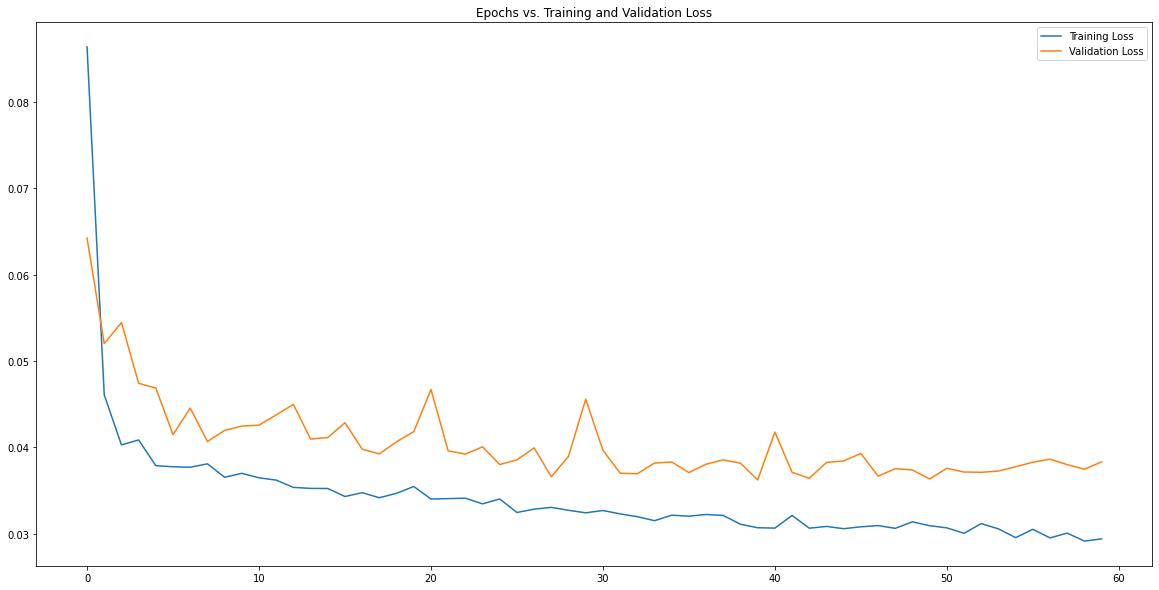

In [69]:
name = '/content/files_DL/mlp.png'
plot_model_loss(history, name)

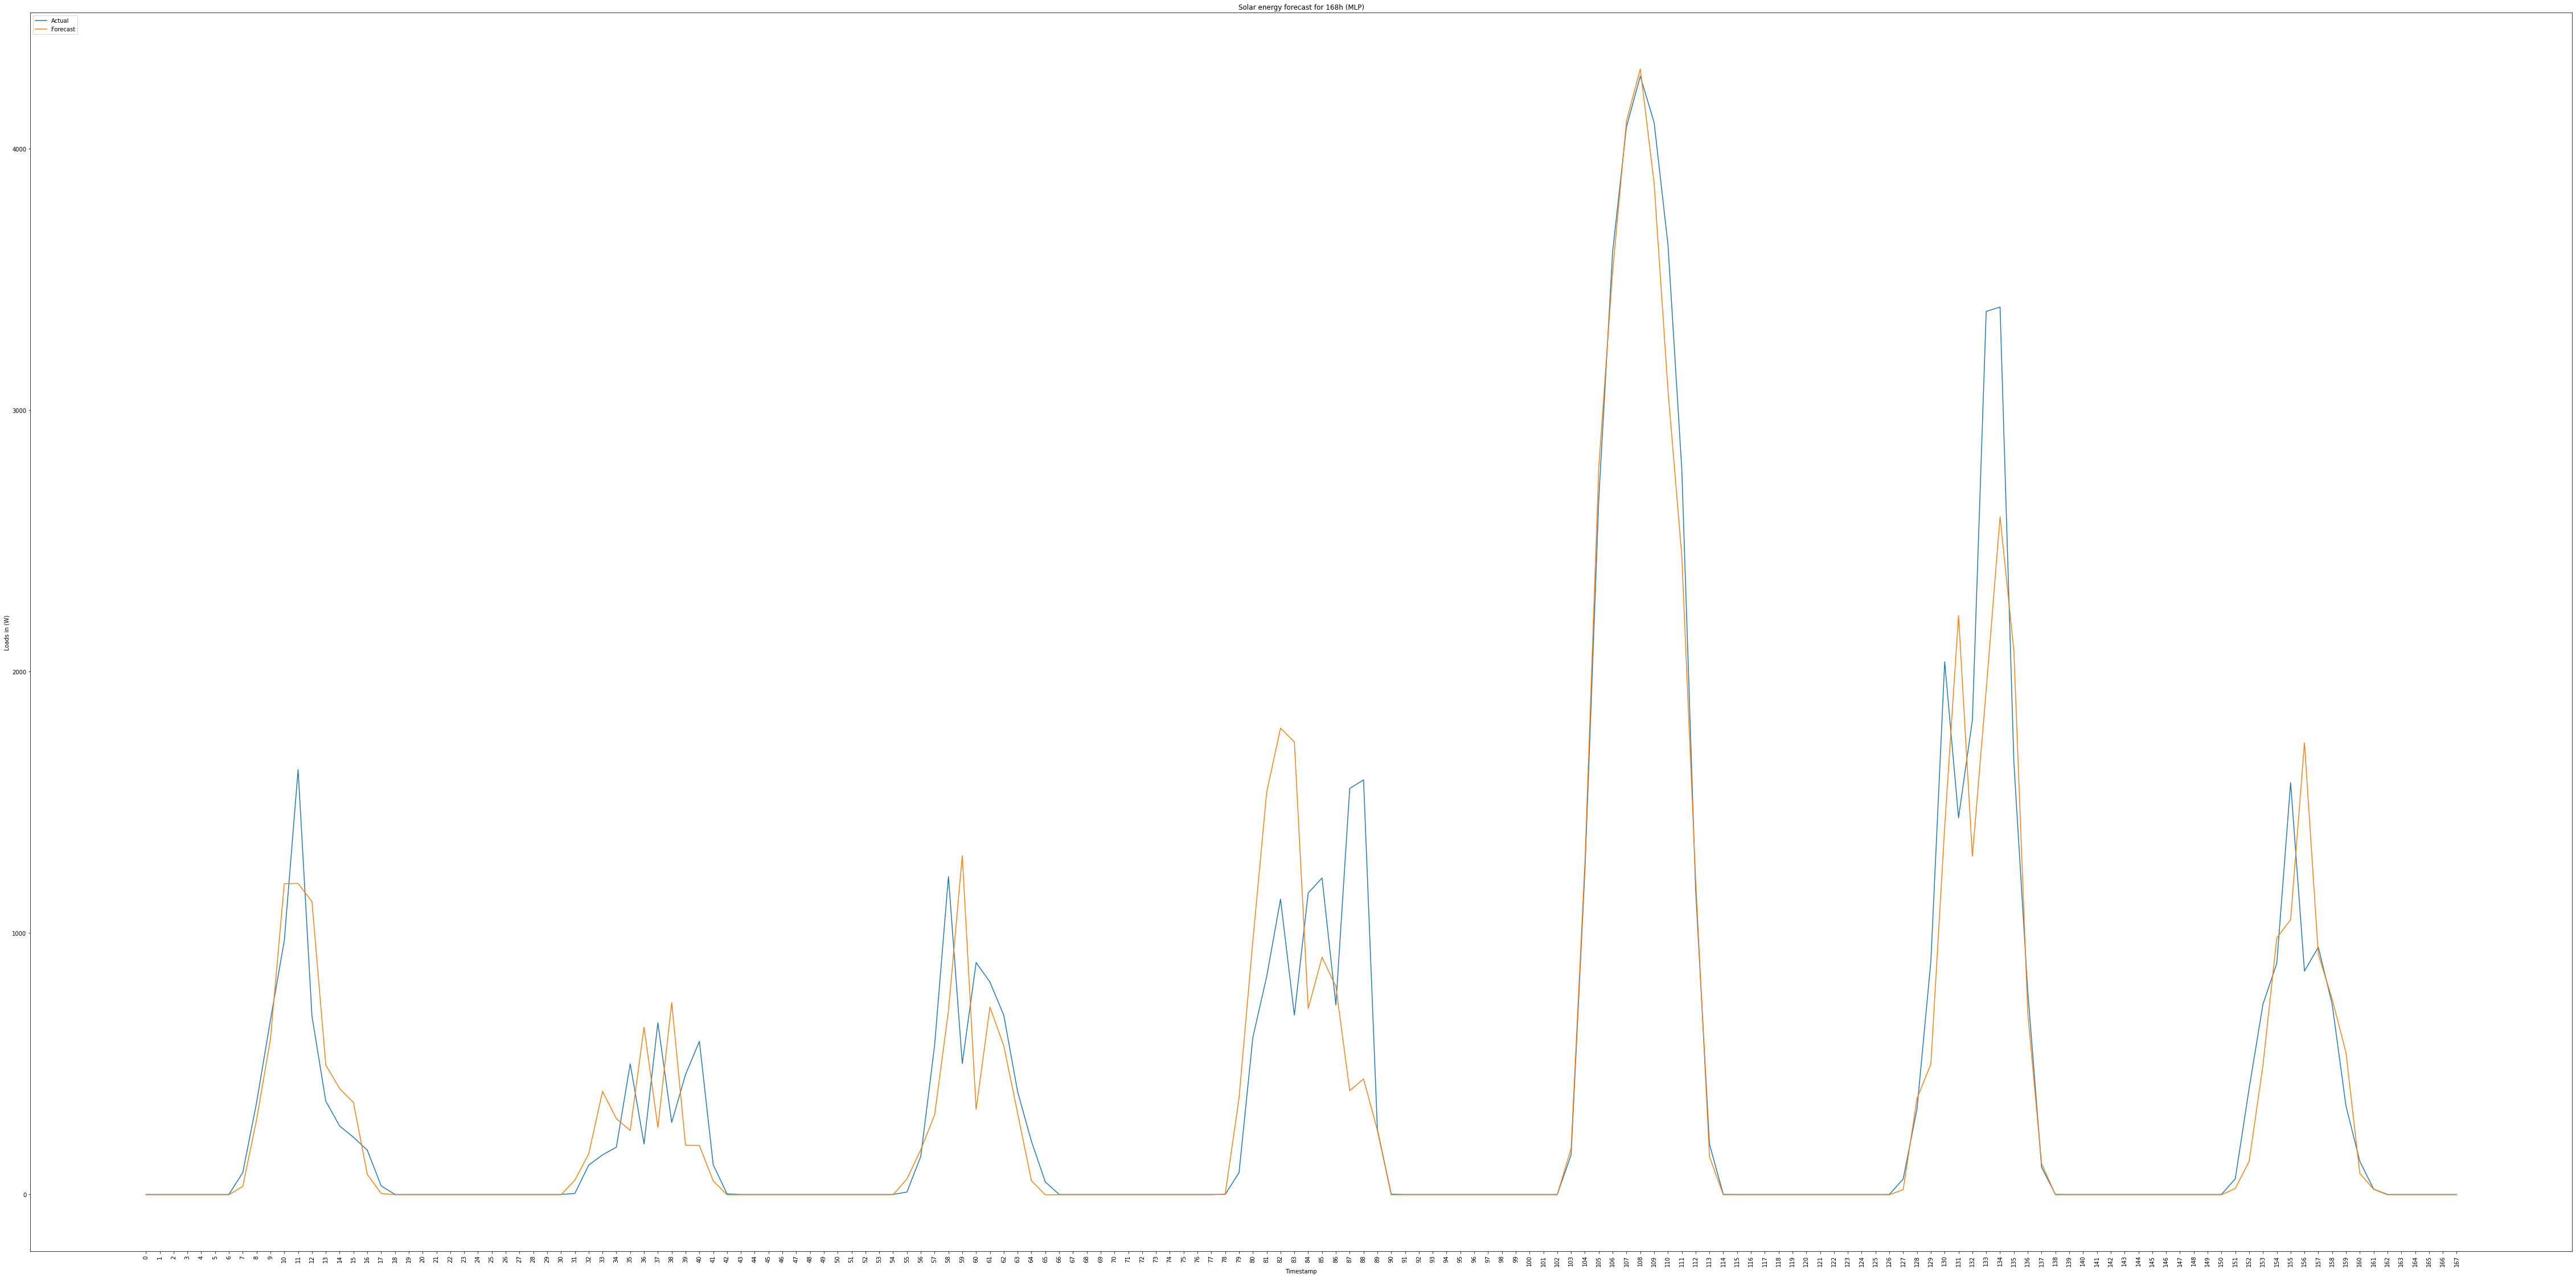

In [70]:
forecast = multivariate_mlp.predict(X_test[-168:])
mlp_forecast = scaler_y.inverse_transform(forecast)


x = []
for i in range(168):
  x.append(str(i))

plt.figure(figsize=(80, 40))
plt.plot(x,scaler_y.inverse_transform(y_test[-168:]), label="Actual")
plt.plot(x,mlp_forecast, label="Forecast")

plt.legend(loc="upper left")

plt.xticks(x)
plt.xlabel('Timestamp')
plt.ylabel('Loads in (W)')
plt.title('Solar energy forecast for 168h (MLP)')
plt.xticks(rotation = 90)
plt.savefig('/content/files_DL/mlp_forecast_actual.png', fontsize=50)
plt.show()

In [71]:
multivariate_mlp = tf.keras.models.load_model('/content/models/multivariate_mlp.h5',
              custom_objects={'root_mean_squared_error':root_mean_squared_error})

forecast = multivariate_mlp.predict(X_test)
mlp_forecast = scaler_y.inverse_transform(forecast)

rmse_mlp_n = sqrt(mean_squared_error(y_test,
                                    forecast))
print('RMSE (Normalized) of MLP forecast: {}'
      .format(round(rmse_mlp_n, 8)))

rmse_mlp = sqrt(mean_squared_error(y_test_inv,
                                    mlp_forecast))
print('RMSE of MLP forecast: {}'
      .format(round(rmse_mlp, 4)))

mae_mlp_n = mean_absolute_error(y_test,
                                    forecast)
print('MAE (Normalized) of MLP forecast: {}'
      .format(round(mae_mlp_n, 8)))

mae_mlp = mean_absolute_error(y_test_inv,
                                    mlp_forecast)
print('MAE of MLP forecast: {}'
      .format(round(mae_mlp, 4)))

RMSE (Normalized) of MLP forecast: 0.0591298
RMSE of MLP forecast: 279.27
MAE (Normalized) of MLP forecast: 0.02837802
MAE of MLP forecast: 134.0294


# **Download the outputs**

In [72]:
# Download all files
!zip -r /content/files_DL.zip /content/files_DL
!zip -r /content/models.zip /content/models

from google.colab import files
files.download('files_DL.zip')
files.download('models.zip')

  adding: content/files_DL/ (stored 0%)
  adding: content/files_DL/cnn_history_lr.png (deflated 10%)
  adding: content/files_DL/gru_forecast_actual.png (deflated 19%)
  adding: content/files_DL/encoder_decoder_history_lr.png (deflated 10%)
  adding: content/files_DL/encoder_decoder_forecast_actual.png (deflated 19%)
  adding: content/files_DL/cnn.png (deflated 14%)
  adding: content/files_DL/gru.png (deflated 12%)
  adding: content/files_DL/lstm_forecast_actual.png (deflated 19%)
  adding: content/files_DL/cnn_forecast_actual.png (deflated 19%)
  adding: content/files_DL/mlp_history_lr.png (deflated 10%)
  adding: content/files_DL/stacked_lstm.png (deflated 13%)
  adding: content/files_DL/gru_history_lr.png (deflated 10%)
  adding: content/files_DL/encoder_decoder.png (deflated 9%)
  adding: content/files_DL/mlp_forecast_actual.png (deflated 20%)
  adding: content/files_DL/mlp.png (deflated 11%)
  adding: content/files_DL/stacked_lstm_history_lr.png (deflated 9%)
  adding: content/file

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **LSTM Hyperparameter Tuning**

In [ ]:
pip install keras-tuner --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 133 kB 31.5 MB/s 


In [ ]:
import keras_tuner as kt

def make_model(hp):
    model = tf.keras.models.Sequential([
    LSTM(hp.Choice('units', [120, 140, 160, 200, 256, 512]), input_shape=input_shape, 
         return_sequences=True),
    Flatten(),
    Dense(200, activation='relu'),
    Dropout(0.20),
    Dense(1)])

    model.compile(loss=loss,
                          optimizer=optimizer,
                          metrics=metric)
    return model
                       

In [ ]:
tuner = kt.RandomSearch(
    make_model,
    objective='val_loss',
    max_trials=10)

In [ ]:
tuner.search(train, epochs=200, validation_data=validation)
best_model = tuner.get_best_models()[0]

Trial 6 Complete [00h 02m 05s]
val_loss: 0.03584740310907364

Best val_loss So Far: 0.035251639783382416
Total elapsed time: 00h 16m 38s
INFO:tensorflow:Oracle triggered exit


In [ ]:
tuner.search_space_summary()

Search space summary
Default search space size: 1
units (Choice)
{'default': 120, 'conditions': [], 'values': [120, 140, 160, 200, 256, 512], 'ordered': True}


In [ ]:
tuner.results_summary()

Results summary
Results in ./untitled_project
Showing 10 best trials
Trial summary
Hyperparameters:
units: 160
Score: 0.035251639783382416
Trial summary
Hyperparameters:
units: 140
Score: 0.03545879200100899
Trial summary
Hyperparameters:
units: 256
Score: 0.035459402948617935
Trial summary
Hyperparameters:
units: 200
Score: 0.03566470369696617
Trial summary
Hyperparameters:
units: 120
Score: 0.03584740310907364
Trial summary
Hyperparameters:
units: 512
Score: 0.20688018202781677


In [ ]:
tf.keras.backend.clear_session()

multivariate_lstm = tf.keras.models.Sequential([
    LSTM(160, input_shape=input_shape, 
         return_sequences=True),
    Flatten(),
    Dense(200, activation='relu'),
    Dropout(0.20),
    Dense(1)
])

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
                   '/content/models/multivariate_lstm_best.h5', monitor=('val_loss'), save_best_only=True)
optimizer = tf.keras.optimizers.Adam(lr=0.001, amsgrad=True)

multivariate_lstm.compile(loss=loss,
                          optimizer=optimizer,
                          metrics=metric)

In [ ]:
history = multivariate_lstm.fit(train, epochs=1000,
                                validation_data=validation,
                                callbacks=[early_stopping,model_checkpoint])

Epoch 1/1000
71/71 [==============================] - 3s 15ms/step - loss: 0.1466 - mse: 0.0731 - mae: 0.1466 - val_loss: 0.0918 - val_mse: 0.0284 - val_mae: 0.0918
Epoch 2/1000
71/71 [==============================] - 1s 9ms/step - loss: 0.0641 - mse: 0.0156 - mae: 0.0641 - val_loss: 0.0784 - val_mse: 0.0208 - val_mae: 0.0784
Epoch 3/1000
71/71 [==============================] - 1s 8ms/step - loss: 0.0591 - mse: 0.0131 - mae: 0.0591 - val_loss: 0.0815 - val_mse: 0.0218 - val_mae: 0.0815
Epoch 4/1000
71/71 [==============================] - 1s 8ms/step - loss: 0.0531 - mse: 0.0106 - mae: 0.0531 - val_loss: 0.0688 - val_mse: 0.0153 - val_mae: 0.0688
Epoch 5/1000
71/71 [==============================] - 1s 9ms/step - loss: 0.0508 - mse: 0.0096 - mae: 0.0508 - val_loss: 0.0625 - val_mse: 0.0128 - val_mae: 0.0625
Epoch 6/1000
71/71 [==============================] - 1s 8ms/step - loss: 0.0488 - mse: 0.0091 - mae: 0.0488 - val_loss: 0.0588 - val_mse: 0.0115 - val_mae: 0.0588
Epoch 7/1000
71

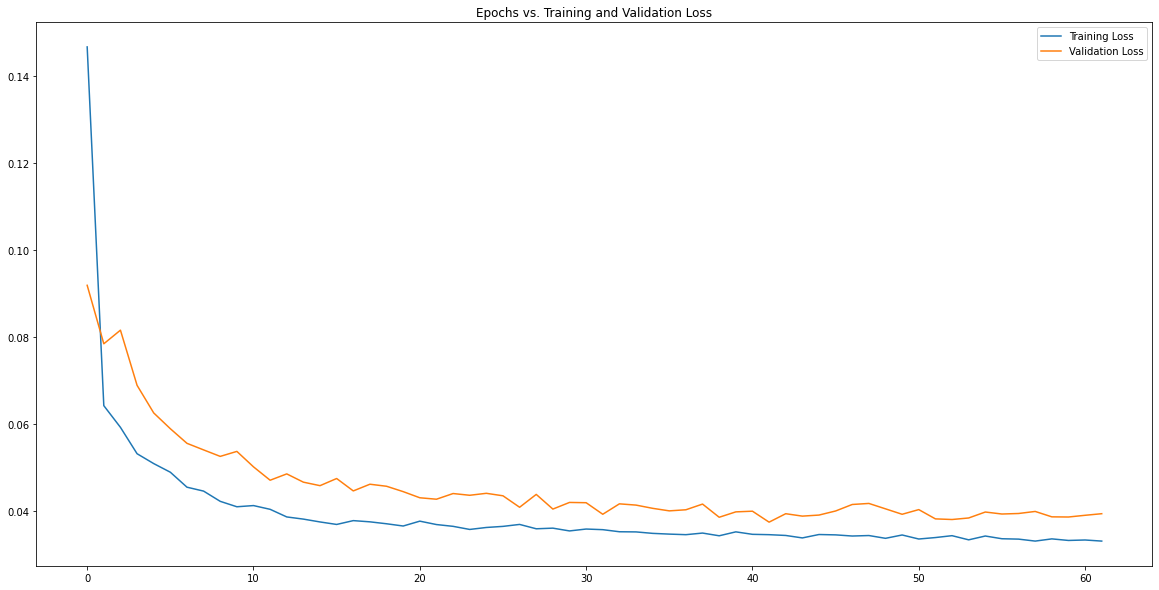

In [ ]:
name = '/content/files_DL/lstm_best.png'
plot_model_loss(history, name)

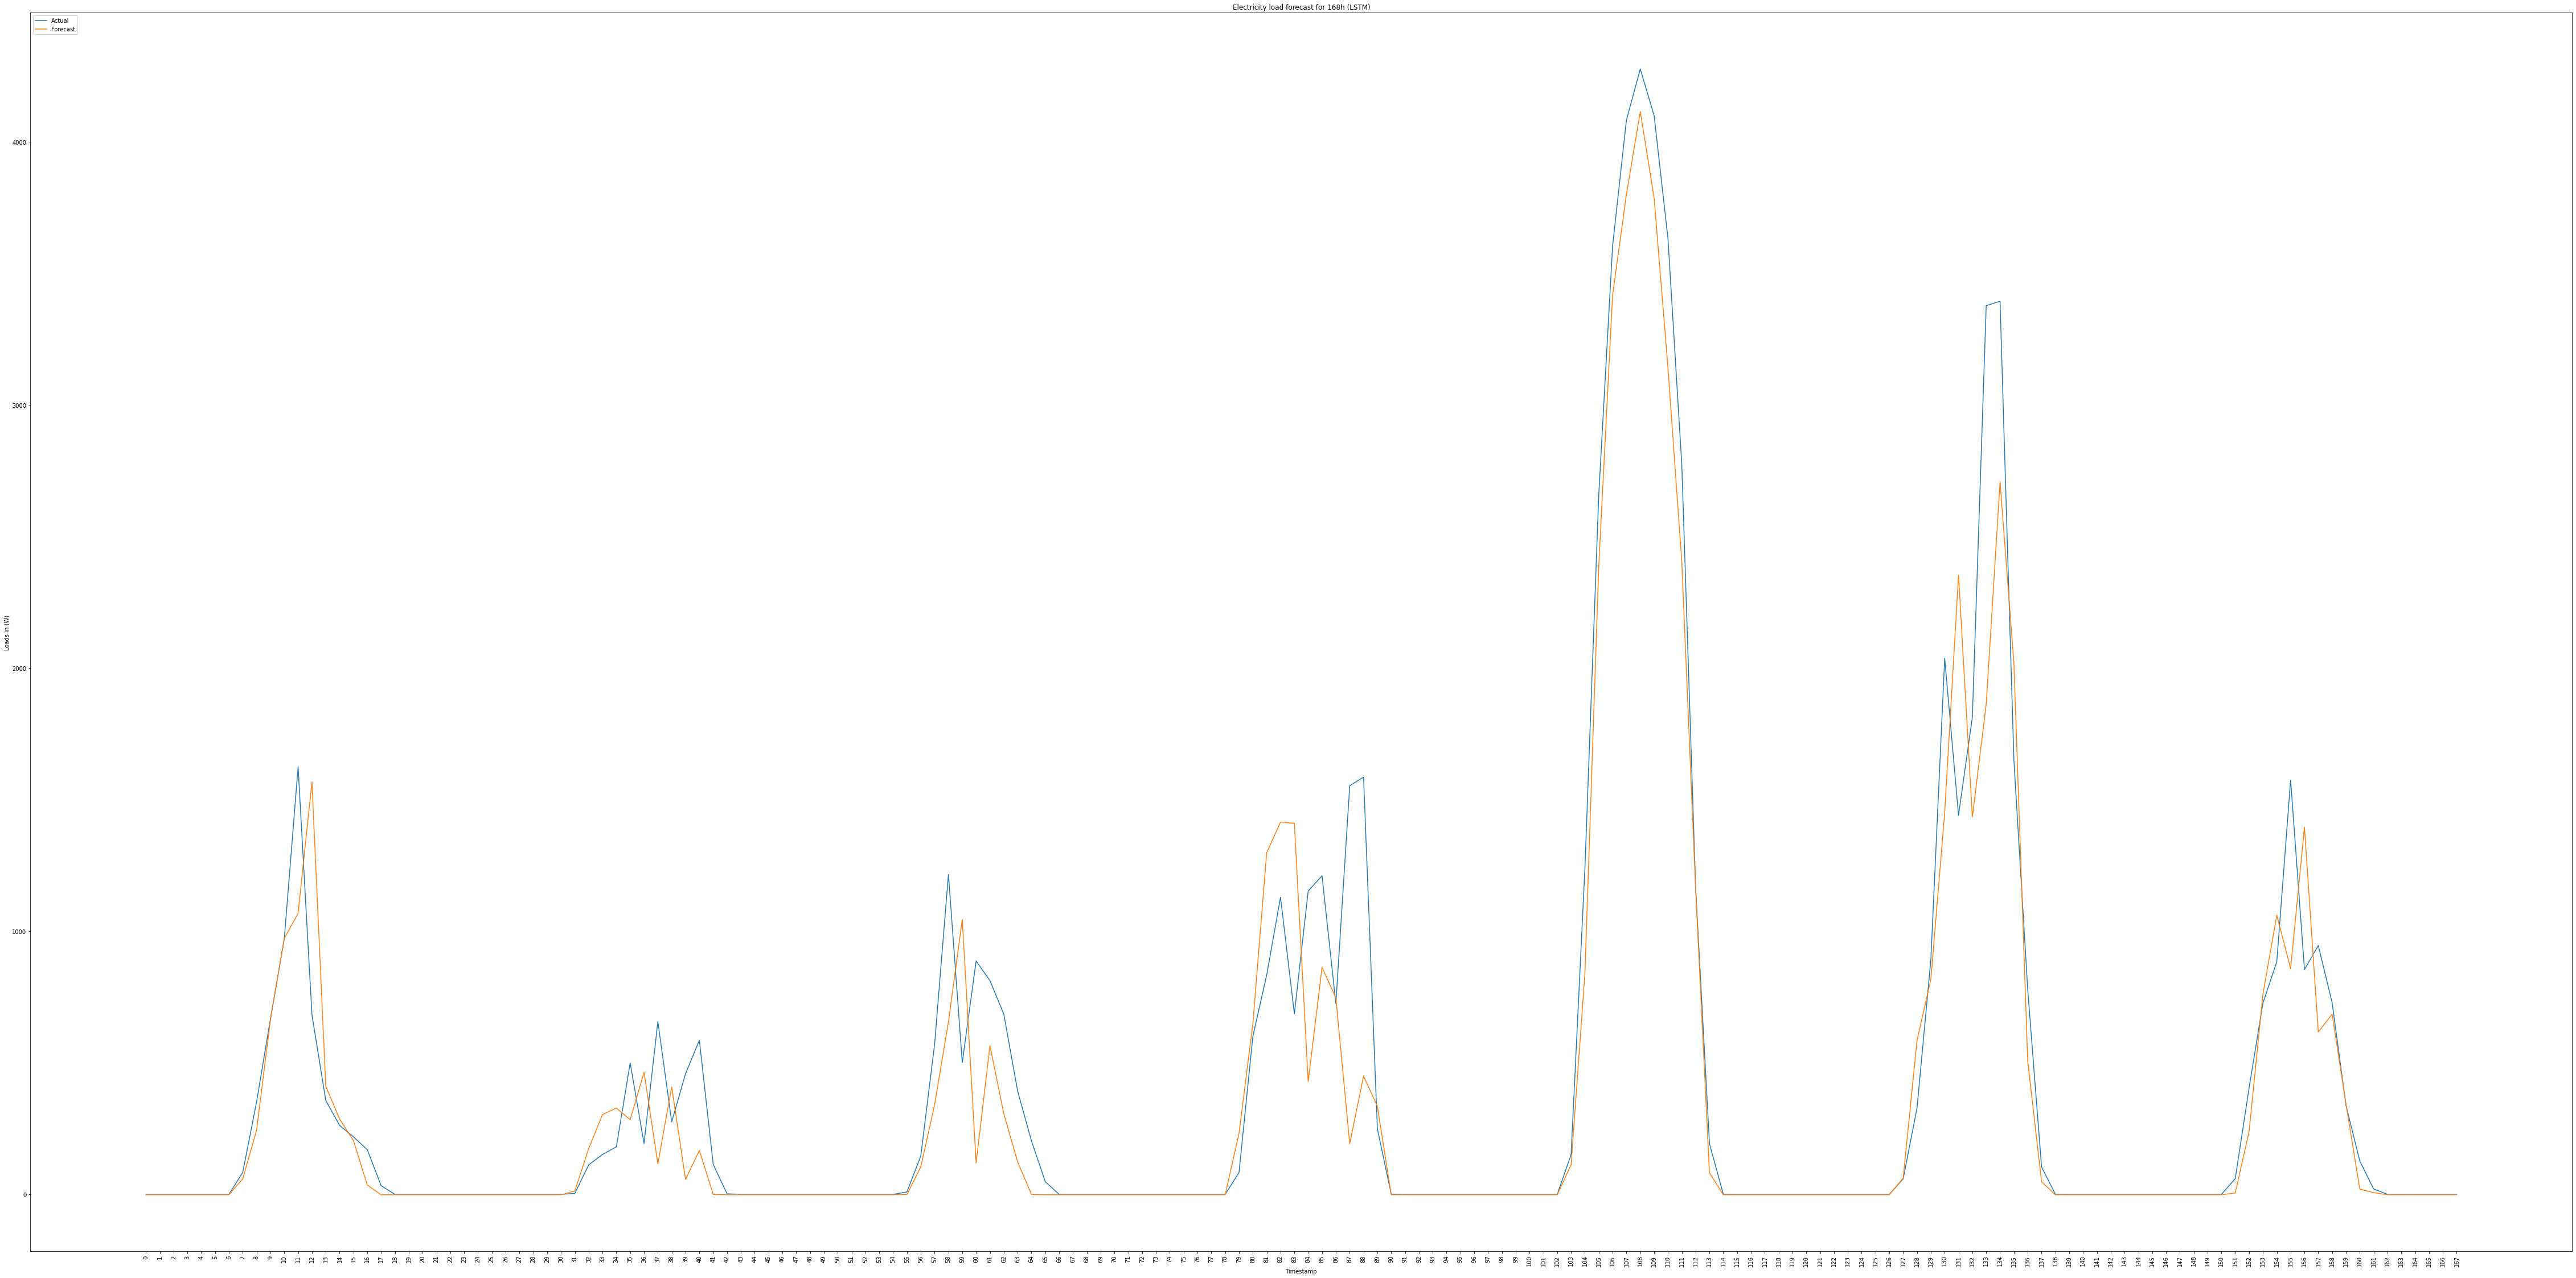

In [ ]:
forecast = multivariate_lstm.predict(X_test[-168:])
lstm_forecast = scaler_y.inverse_transform(forecast)


x = []
for i in range(168):
  x.append(str(i))

plt.figure(figsize=(80, 40))
plt.plot(x,scaler_y.inverse_transform(y_test[-168:]), label="Actual")
plt.plot(x,lstm_forecast, label="Forecast")

plt.legend(loc="upper left")

plt.xticks(x)
plt.xlabel('Timestamp')
plt.ylabel('Loads in (W)')
plt.title('Electricity load forecast for 168h (LSTM)')
plt.xticks(rotation = 90)
plt.savefig('/content/files_DL/lstm_best_forecast_actual.png')
plt.show()

In [ ]:
multivariate_lstm = tf.keras.models.load_model('/content/models/multivariate_lstm_best.h5',
              custom_objects={'root_mean_squared_error':root_mean_squared_error})

forecast = multivariate_lstm.predict(X_test)
lstm_forecast = scaler_y.inverse_transform(forecast)

rmse_lstm_n = sqrt(mean_squared_error(y_test,
                                    forecast))
print('RMSE (Normalized) of LSTM forecast: {}'
      .format(round(rmse_lstm_n, 8)))

rmse_lstm = sqrt(mean_squared_error(y_test_inv,
                                    lstm_forecast))
print('RMSE of LSTM forecast: {}'
      .format(round(rmse_lstm, 4)))

mae_lstm_n = mean_absolute_error(y_test,
                                    forecast)
print('MAE (Normalized) of LSTM forecast: {}'
      .format(round(mae_lstm_n, 8)))

mae_lstm = mean_absolute_error(y_test_inv,
                                    lstm_forecast)
print('MAE of LSTM forecast: {}'
      .format(round(mae_lstm, 4)))

RMSE (Normalized) of LSTM forecast: 0.05956811
RMSE of LSTM forecast: 281.3402
MAE (Normalized) of LSTM forecast: 0.02788969
MAE of LSTM forecast: 131.723


In [ ]:
# Download all files
!zip -r /content/files_DL.zip /content/files_DL
!zip -r /content/models.zip /content/models

from google.colab import files
files.download('files_DL.zip')
files.download('models.zip')

  adding: content/files_DL/ (stored 0%)
  adding: content/files_DL/mlp_forecast_actual.png (deflated 20%)
  adding: content/files_DL/mlp.png (deflated 12%)
  adding: content/files_DL/cnn.png (deflated 15%)
  adding: content/files_DL/stacked_lstm_history_lr.png (deflated 9%)
  adding: content/files_DL/cnn_history_lr.png (deflated 12%)
  adding: content/files_DL/gru_forecast_actual.png (deflated 19%)
  adding: content/files_DL/gru.png (deflated 15%)
  adding: content/files_DL/cnn_forecast_actual.png (deflated 19%)
  adding: content/files_DL/stacked_lstm (deflated 13%)
  adding: content/files_DL/lstm_best.png (deflated 14%)
  adding: content/files_DL/encoder_decoder_forecast_actual.png (deflated 19%)
  adding: content/files_DL/lstm_best_forecast_actual.png (deflated 19%)
  adding: content/files_DL/lstm.png (deflated 13%)
  adding: content/files_DL/lstm_forecast_actual.png (deflated 19%)
  adding: content/files_DL/mlp_history_lr.png (deflated 8%)
  adding: content/files_DL/stacked_lstm_for

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>